### יבוא סיפריות 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting  # נדרש עבור HistGradientBoostingClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, 
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    HistGradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split, 
    RepeatedStratifiedKFold, 
    RandomizedSearchCV, 
    StratifiedShuffleSplit
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    roc_auc_score, 
    recall_score, 
    precision_score, 
    f1_score, 
    auc, 
    precision_recall_curve, 
    make_scorer, 
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance
from sklearn.ensemble import VotingClassifier
from imblearn.under_sampling import RandomUnderSampler

from scipy import stats
from scipy.stats import chisquare
from scipy.interpolate import interp1d

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Set seaborn style for plots
sns.set_style('darkgrid')

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")


C:\Users\97254\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# EDA

In [2]:
df = pd.read_csv("Roni Project (2).csv")
df = df.copy()
# Rename columns to lowercase
df.columns = df.columns.str.lower()

# Display the shape and columns
print(df.shape)
print(df.columns)
df.describe()
df.info()

(71991, 28)
Index(['user', 'deposit_attempts', 'sucess_deposit_attempts', 'num_crads',
       'num_crads_success', 'first_deposit_date', 'last_deposit_date',
       'deposit_sucess_ratio', 'deposit_time_delta', 'signup_time_delta',
       'calls', 'docs_uploaded', 'docs_approved', 'approval_rate',
       'sales_view', 'conversion_owner', 'sales_agent',
       'account_create_on_date', 'country_name', 'tag', 'channel',
       'ava_business', 'profile_state', 'num_closed_trades',
       'business_group_name', 'first_closed_trade_date',
       'last_closed_trade_date', 'is_ch_back'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71991 entries, 0 to 71990
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user                     71991 non-null  int64  
 1   deposit_attempts         71991 non-null  int64  
 2   sucess_deposit_attempts  71991 non-null  int64  
 3   num_cr

### המרת לפורמט של תאריך

In [3]:

df['first_deposit_date'] = pd.to_datetime(df['first_deposit_date'])
df['last_deposit_date'] = pd.to_datetime(df['last_deposit_date'])
df['account_create_on_date'] = pd.to_datetime(df['account_create_on_date'])
df['first_closed_trade_date'] = pd.to_datetime(df['first_closed_trade_date'])
df['last_closed_trade_date'] = pd.to_datetime(df['last_closed_trade_date'])


### למידה על ערכים חסרים 

In [4]:
# בדיקת חוסר בנתונים
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])
# בדיקת כמות השורות שבהן הערך של num_crads הוא אפס
num_crads_zero_count = (df['num_crads'] == 0).sum()
print(f"Number of rows where 'num_crads' is zero: {num_crads_zero_count}")

# מספר השורות עם ערך חסר בעמודה 'last_deposit_date'
num_missing_last_deposit_date = df['last_deposit_date'].isnull().sum()
print(f"Number of rows with missing 'last_deposit_date': {num_missing_last_deposit_date}")

# שמירת הדאטה פריים לאחר הסרת השורות עם ערך חסר בעמודה 'last_deposit_date'
df_cleaned_last_deposit = df.dropna(subset=['last_deposit_date'])

# מספר השורות בהן 'is_ch_back' הוא 1 לאחר הניקוי
num_ch_back_1_after_cleaning = df_cleaned_last_deposit['is_ch_back'].sum()
print(f"Number of rows where 'is_ch_back' is 1 after cleaning rows with missing 'last_deposit_date': {num_ch_back_1_after_cleaning}")


last_deposit_date            16
first_closed_trade_date    7171
last_closed_trade_date     7171
dtype: int64
Number of rows where 'num_crads' is zero: 19954
Number of rows with missing 'last_deposit_date': 16
Number of rows where 'is_ch_back' is 1 after cleaning rows with missing 'last_deposit_date': 301



### חישוב עמודות חדשות 

In [5]:
# רשימת עמודות בהן יש להחליף ערכים של 0 בערכים חסרים
columns_to_replace_zeros = ['deposit_attempts', 'sucess_deposit_attempts', 'num_crads', 'num_crads_success']

# החלפת ערכים של 0 בערכים חסרים (NaN)
df[columns_to_replace_zeros] = df[columns_to_replace_zeros].replace(0, np.nan)

# הפרש ימים בין ההפקדה הראשונה להפקדה האחרונה
df['days_between_deposits'] = (df['last_deposit_date'] - df['first_deposit_date']).dt.days

# הפרש ימים בין יצירת החשבון להפקדה הראשונה
df['days_to_first_deposit'] = (df['first_deposit_date'] - df['account_create_on_date']).dt.days

# הפרש ימים בין העסקה הסגורה הראשונה לעסקה הסגורה האחרונה
df['days_between_trades'] = (df['last_closed_trade_date'] - df['first_closed_trade_date']).dt.days

# יחס הצלחה של עסקאות סגורות
df['success_ratio_crads'] = df['num_crads_success'] / df['num_crads']

# יחס אישור מסמכים
df['approval_ratio_docs'] = df['docs_approved'] / df['docs_uploaded']

# זמן ממוצע בין הפקדות
df['avg_days_between_deposits'] = df['deposit_time_delta'] / df['deposit_attempts']

# זמן ממוצע בין עסקאות סגורות
df['avg_days_between_trades'] = df['signup_time_delta'] / df['num_closed_trades']

# חודש ההפקדה הראשונה
df['first_deposit_month'] = df['first_deposit_date'].dt.month

# חודש ההפקדה האחרונה
df['last_deposit_month'] = df['last_deposit_date'].dt.month

# יום בשבוע של ההפקדה הראשונה
df['first_deposit_weekday'] = df['first_deposit_date'].dt.weekday

# הצגת התוצאות
print(df.shape)
print(df.columns)

(71991, 38)
Index(['user', 'deposit_attempts', 'sucess_deposit_attempts', 'num_crads',
       'num_crads_success', 'first_deposit_date', 'last_deposit_date',
       'deposit_sucess_ratio', 'deposit_time_delta', 'signup_time_delta',
       'calls', 'docs_uploaded', 'docs_approved', 'approval_rate',
       'sales_view', 'conversion_owner', 'sales_agent',
       'account_create_on_date', 'country_name', 'tag', 'channel',
       'ava_business', 'profile_state', 'num_closed_trades',
       'business_group_name', 'first_closed_trade_date',
       'last_closed_trade_date', 'is_ch_back', 'days_between_deposits',
       'days_to_first_deposit', 'days_between_trades', 'success_ratio_crads',
       'approval_ratio_docs', 'avg_days_between_deposits',
       'avg_days_between_trades', 'first_deposit_month', 'last_deposit_month',
       'first_deposit_weekday'],
      dtype='object')


### למידה נוספת על ערכים חסרים 

In [45]:
# בדיקת חוסר בנתונים
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

# ניקוי הערכים החסרים מכל השורות
df_cleaned = df.dropna()

# הצגת צורת הדאטה אחרי הניקוי
print("Dataframe shape after cleaning:", df_cleaned.shape)

# בדיקה כמה שורות יש להן ערך 1 בעמודה 'is_ch_back' אחרי הניקוי
num_ch_back_1_after = df_cleaned['is_ch_back'].sum()
print(f"Number of rows where 'is_ch_back' is 1 after cleaning: {num_ch_back_1_after}")
# בדיקת חוסר בנתונים
missing_data = df.isnull().sum()
print("Missing data in each column:")
print(missing_data[missing_data > 0])

# בדיקה כמה שורות יש להן ערך 1 בעמודה 'is_ch_back'
num_ch_back_1 = df['is_ch_back'].sum()
print(f"Number of rows where 'is_ch_back' is 1: {num_ch_back_1}")


last_deposit_date            16
first_closed_trade_date    7171
last_closed_trade_date     7171
dtype: int64
Dataframe shape after cleaning: (64795, 38)
Number of rows where 'is_ch_back' is 1 after cleaning: 282
Missing data in each column:
last_deposit_date            16
first_closed_trade_date    7171
last_closed_trade_date     7171
dtype: int64
Number of rows where 'is_ch_back' is 1: 304


## טיפול בערכים חסרים 

In [46]:
# deposit_attempts
# מילוי בממוצע העמודה כדי לשמור על ערכים מתונים
df['deposit_attempts'].fillna(df['deposit_attempts'].mean(), inplace=True)

# sucess_deposit_attempts
# מילוי בממוצע העמודה כדי לשמור על ערכים מתונים
df['sucess_deposit_attempts'].fillna(df['sucess_deposit_attempts'].mean(), inplace=True)

# num_crads
# מילוי בממוצע העמודה כדי לשמור על ערכים מתונים
df['num_crads'].fillna(df['num_crads'].mean(), inplace=True)

# num_crads_success
# מילוי בממוצע העמודה כדי לשמור על ערכים מתונים
df['num_crads_success'].fillna(df['num_crads_success'].mean(), inplace=True)

# days_between_deposits
# מילוי בממוצע העמודה כדי לשמור על ערכים מתונים
df['days_between_deposits'].fillna(df['days_between_deposits'].mean(), inplace=True)

# days_between_trades
# מילוי בממוצע העמודה כדי להימנע מהכנסת הטיה משמעותית
df['days_between_trades'].fillna(df['days_between_trades'].mean(), inplace=True)

# success_ratio_crads
# מילוי בערך 0 מכיוון שמשתמשים עם ערכים חסרים הם כנראה משתמשים שלא ביצעו עסקאות עם כרטיסים
df['success_ratio_crads'].fillna(0, inplace=True)

# approval_ratio_docs
# מילוי בממוצע העמודה כדי לשמור על ערך מתון
df['approval_ratio_docs'].fillna(df['approval_ratio_docs'].mean(), inplace=True)

# avg_days_between_deposits
# מילוי בממוצע העמודה כדי לשמור על הערכים המתונים
df['avg_days_between_deposits'].fillna(df['avg_days_between_deposits'].mean(), inplace=True)

# טיפול בחלוקה באפס בעמודה avg_days_between_trades
# אם num_crads הוא אפס, נחליף אותו בערך קטן מאוד כדי להימנע מחלוקה באפס
df['avg_days_between_trades'] = np.where(df['num_crads'] == 0, 0, df['signup_time_delta'] / df['num_crads'])

# המרת ערכים אינסופיים לאפס
df['avg_days_between_trades'].replace([np.inf, -np.inf], 0, inplace=True)

# last_deposit_month
# מילוי בשכיח כדי לשמור על הדפוס העונתי הקיים
df['last_deposit_month'].fillna(df['last_deposit_month'].mode()[0], inplace=True)



## טיפול בערכים חריגים

In [8]:
df.describe()

,user,deposit_attempts,sucess_deposit_attempts,num_crads,num_crads_success,first_deposit_date,last_deposit_date,deposit_sucess_ratio,deposit_time_delta,signup_time_delta,...,days_between_deposits,days_to_first_deposit,days_between_trades,success_ratio_crads,approval_ratio_docs,avg_days_between_deposits,avg_days_between_trades,first_deposit_month,last_deposit_month,first_deposit_weekday
count,7.199100e+04,71991.000000,71991.000000,71991.000000,71991.000000,71991,71975,71991.000000,71991.000000,71991.000000,...,71991.000000,71991.000000,71991.000000,71991.000000,71991.000000,71991.000000,71991.000000,71991.00000,71991.000000,71991.000000
mean,1.530909e+07,5.898015,3.813582,1.424141,1.194293,2023-10-20 04:15:09.113639168,2023-12-09 16:03:34.474470400,0.529906,50.462336,84.501924,...,50.473553,84.501924,102.946313,0.624953,0.736464,10.565712,68.617331,5.66368,5.852107,2.267311
min,1.275200e+04,1.000000,1.000000,1.000000,1.000000,2023-01-01 00:00:00,2023-01-01 00:00:00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000
25%,1.482546e+07,1.000000,1.000000,1.000000,1.000000,2023-06-05 00:00:00,2023-07-31 00:00:00,0.000000,0.000000,0.000000,...,0.000000,0.000000,14.000000,0.000000,0.500000,0.000000,0.000000,3.00000,3.000000,1.000000
50%,1.562800e+07,4.000000,3.000000,1.000000,1.000000,2023-10-16 00:00:00,2023-12-28 00:00:00,0.500000,0.000000,3.000000,...,0.000000,3.000000,66.000000,1.000000,0.736464,5.000000,2.106534,5.00000,6.000000,2.000000
75%,1.607297e+07,5.898015,3.813582,1.424141,1.194293,2024-03-08 00:00:00,2024-05-07 00:00:00,1.000000,49.000000,20.000000,...,49.000000,20.000000,134.000000,1.000000,1.000000,10.565712,15.000000,8.00000,8.000000,4.000000
max,1.654494e+07,830.000000,549.000000,56.000000,20.000000,2024-07-29 00:00:00,2024-07-29 00:00:00,1.000000,570.000000,6040.000000,...,570.000000,6040.000000,3550.000000,1.000000,1.000000,548.000000,6040.000000,12.00000,12.000000,6.000000
std,1.363853e+06,12.807236,8.583275,0.912461,0.505991,NaN,NaN,0.432954,100.406022,302.510988,...,100.403203,302.510988,118.949288,0.457117,0.278005,25.178986,256.995770,3.24145,3.050827,1.747603


In [9]:
#יורדים 4 שורות
df = df[df['calls'] <= 750]
# יורדים 6 שורות
df = df[df['docs_uploaded'] <100]
#יורד שורה אחת
df = df[df['days_to_first_deposit'] < 6039]

## heatmap of correlation

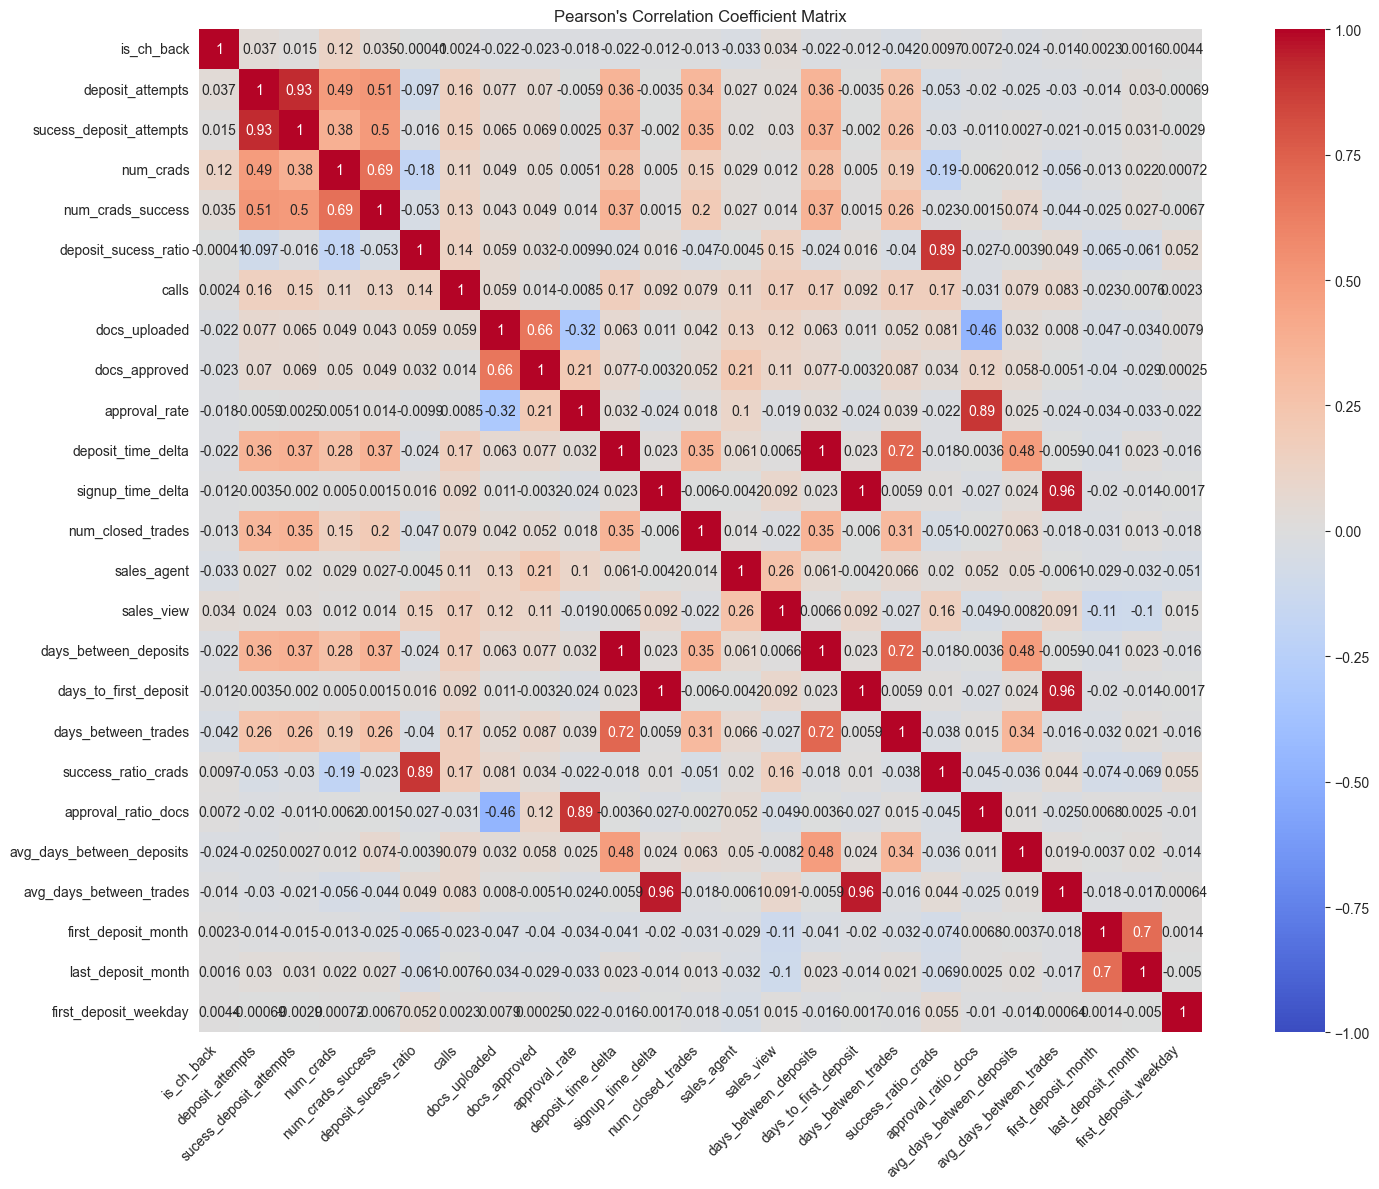

In [10]:

# Define features (after verifying the column names)
features = ['is_ch_back', 'deposit_attempts', 'sucess_deposit_attempts', 'num_crads', 'num_crads_success', 
            'deposit_sucess_ratio', 'calls', 'docs_uploaded', 'docs_approved', 'approval_rate', 
            'deposit_time_delta', 'signup_time_delta', 'num_closed_trades', 'sales_agent', 'sales_view', 
            'days_between_deposits', 'days_to_first_deposit', 'days_between_trades', 'success_ratio_crads', 
            'approval_ratio_docs', 'avg_days_between_deposits', 'avg_days_between_trades', 'first_deposit_month', 
            'last_deposit_month', 'first_deposit_weekday']

# Filter out the features that are actually present in the DataFrame
existing_features = [feature for feature in features if feature in df.columns]

# Calculate the Pearson's correlation matrix
correlation_matrix = df[existing_features].corr()

# Create a heatmap to display the correlation matrix
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)

# Adjusting the labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.title("Pearson's Correlation Coefficient Matrix")
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()


### הצגת התפלגות הנתונים 

In [12]:
'''
# Set the number of columns per row
columns_per_row = 1

# Calculate the number of required rows
num_rows = len(df.columns)

# Create subplots with one column per row
fig, axes = plt.subplots(nrows=num_rows, ncols=columns_per_row, figsize=(10, 5*num_rows))

# Plot histograms for numerical columns and bar plots for categorical columns
for i, column in enumerate(df.columns):
    if df[column].dtype == 'int64' or df[column].dtype == 'float64':
        sns.histplot(data=df, x=column, kde=False, ax=axes[i])
        axes[i].set_yscale('log')  # Set log scale for y-axis
    else:
        sns.countplot(data=df, x=column, ax=axes[i])
        axes[i].set_yscale('log')  # Set log scale for y-axis
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency (log scale)')

plt.tight_layout()
plt.show()
'''

"\n# Set the number of columns per row\ncolumns_per_row = 1\n\n# Calculate the number of required rows\nnum_rows = len(df.columns)\n\n# Create subplots with one column per row\nfig, axes = plt.subplots(nrows=num_rows, ncols=columns_per_row, figsize=(10, 5*num_rows))\n\n# Plot histograms for numerical columns and bar plots for categorical columns\nfor i, column in enumerate(df.columns):\n    if df[column].dtype == 'int64' or df[column].dtype == 'float64':\n        sns.histplot(data=df, x=column, kde=False, ax=axes[i])\n        axes[i].set_yscale('log')  # Set log scale for y-axis\n    else:\n        sns.countplot(data=df, x=column, ax=axes[i])\n        axes[i].set_yscale('log')  # Set log scale for y-axis\n    axes[i].set_title(f'Distribution of {column}')\n    axes[i].set_xlabel(column)\n    axes[i].set_ylabel('Frequency (log scale)')\n\nplt.tight_layout()\nplt.show()\n"

### הצגת התפלגות הנתונים לאחר חלוקה לפי הכשת עסקה

In [13]:
'''
df_0 = df[df['is_ch_back'] == 0]
df_1 = df[df['is_ch_back'] == 1]


# Set the number of columns per row
columns_per_row = 1

# Calculate the number of required rows
num_rows = max(len(df_0.columns), len(df_1.columns))

# Create subplots with one row and two columns
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(11, 2*num_rows))  # Adjust the height as needed

# Set titles for the entire figure
#fig.suptitle('Distribution of Features for df_0 and df_1 ', fontsize=16)

# Plot histograms for numerical columns and bar plots for categorical columns for df_0
for i, column in enumerate(df_0.columns):
    if df_0[column].dtype == 'int64' or df_0[column].dtype == 'float64':
        sns.histplot(data=df_0, x=column, kde=False, ax=axes[i, 0])
    else:
        sns.countplot(data=df_0, x=column, ax=axes[i, 0])
   
    axes[i, 0].set_title(f'Distribution of {column} (df_0)')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')

# Plot histograms for numerical columns and bar plots for categorical columns for df_1
for i, column in enumerate(df_1.columns):
    if df_1[column].dtype == 'int64' or df_1[column].dtype == 'float64':
        sns.histplot(data=df_1, x=column, kde=False, ax=axes[i, 1])
    else:
        sns.countplot(data=df_1, x=column, ax=axes[i, 1])
   
    axes[i, 1].set_title(f'Distribution of {column} (df_1)')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
'''

"\ndf_0 = df[df['is_ch_back'] == 0]\ndf_1 = df[df['is_ch_back'] == 1]\n\n\n# Set the number of columns per row\ncolumns_per_row = 1\n\n# Calculate the number of required rows\nnum_rows = max(len(df_0.columns), len(df_1.columns))\n\n# Create subplots with one row and two columns\nfig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(11, 2*num_rows))  # Adjust the height as needed\n\n# Set titles for the entire figure\n#fig.suptitle('Distribution of Features for df_0 and df_1 ', fontsize=16)\n\n# Plot histograms for numerical columns and bar plots for categorical columns for df_0\nfor i, column in enumerate(df_0.columns):\n    if df_0[column].dtype == 'int64' or df_0[column].dtype == 'float64':\n        sns.histplot(data=df_0, x=column, kde=False, ax=axes[i, 0])\n    else:\n        sns.countplot(data=df_0, x=column, ax=axes[i, 0])\n   \n    axes[i, 0].set_title(f'Distribution of {column} (df_0)')\n    axes[i, 0].set_xlabel(column)\n    axes[i, 0].set_ylabel('Frequency')\n\n# Plot hi

In [14]:
df

,user,deposit_attempts,sucess_deposit_attempts,num_crads,num_crads_success,first_deposit_date,last_deposit_date,deposit_sucess_ratio,deposit_time_delta,signup_time_delta,...,days_between_deposits,days_to_first_deposit,days_between_trades,success_ratio_crads,approval_ratio_docs,avg_days_between_deposits,avg_days_between_trades,first_deposit_month,last_deposit_month,first_deposit_weekday
0,15845499,5.898015,3.813582,1.424141,1.194293,2023-12-18,2024-04-25,0.000000,129,17,...,129.0,17,220.0,0.0,1.000000,10.565712,11.937024,12,4.0,0
1,16093620,1.000000,1.000000,1.000000,1.000000,2024-05-24,2024-05-24,1.000000,0,95,...,0.0,95,60.0,1.0,1.000000,0.000000,95.000000,5,5.0,4
2,16088731,5.898015,3.813582,1.424141,1.194293,2024-07-02,2024-07-02,0.000000,0,135,...,0.0,135,23.0,0.0,0.909091,10.565712,94.794017,7,7.0,1
3,16321960,7.000000,4.000000,2.000000,2.000000,2024-05-08,2024-07-09,0.571429,62,0,...,62.0,0,77.0,1.0,1.000000,8.857143,0.000000,5,7.0,2
4,15011904,5.898015,3.813582,1.424141,1.194293,2023-06-14,2023-06-14,0.000000,0,0,...,0.0,0,0.0,0.0,0.076923,10.565712,0.000000,6,6.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71986,16428364,2.000000,1.000000,1.000000,1.000000,2024-06-16,2024-06-16,0.500000,0,0,...,0.0,0,0.0,1.0,0.666667,0.000000,0.000000,6,6.0,6
71987,16410162,1.000000,1.000000,1.000000,1.000000,2024-06-11,2024-06-11,1.000000,0,2,...,0.0,2,45.0,1.0,0.285714,0.000000,2.000000,6,6.0,1
71988,16021854,1.000000,1.000000,1.000000,1.000000,2024-01-28,2024-01-28,1.000000,0,1,...,0.0,1,122.0,1.0,0.500000,0.000000,1.000000,1,1.0,6
71989,15882594,5.898015,3.813582,1.424141,1.194293,2024-01-23,2024-01-23,0.000000,0,40,...,0.0,40,36.0,0.0,1.000000,10.565712,28.087116,1,1.0,1


### הצגת התפלגות משתנה המטרה 

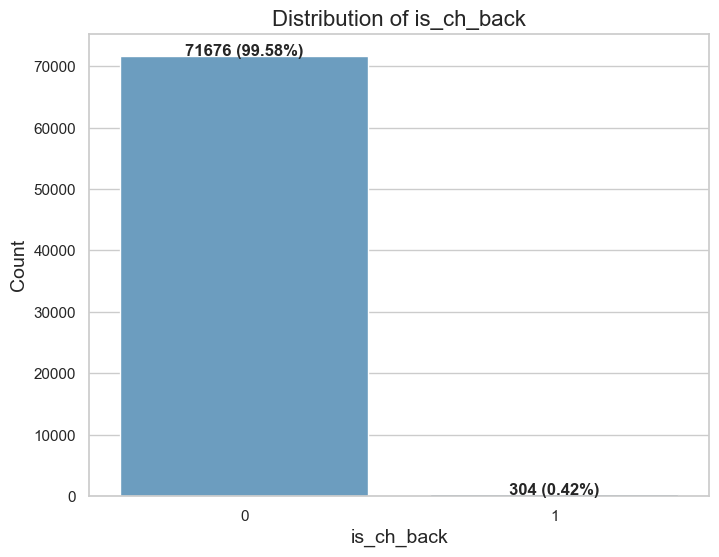

In [48]:

# יצירת טבלת סיכום להתפלגות
distribution = df['is_ch_back'].value_counts(normalize=False)
percentages = df['is_ch_back'].value_counts(normalize=True) * 100

# יצירת גרף עמודות עם תוויות אחוזים וכמויות
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=distribution.index, y=distribution.values, palette='Blues_d')

# הוספת תוויות עם אחוזים וכמויות
for i, (count, percentage) in enumerate(zip(distribution.values, percentages.values)):
    ax.text(i, count + 0.02, f'{count} ({percentage:.2f}%)', ha='center', fontsize=12, fontweight='bold')

# הגדרת כותרות וצירים
plt.title('Distribution of is_ch_back', fontsize=16)
plt.xlabel('is_ch_back', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.show()


### חלוקה לאימון ומבחן בשיטה שמוודאה יחסים מתאימים בעמודת המטרה

In [15]:
# רשימת כל העמודות
cols = df.columns.tolist()

# הסרת עמודת היעד 'is_ch_back' מרשימת העמודות
cols = [c for c in cols if c not in ['is_ch_back']]

# הגדרת עמודת היעד
target = 'is_ch_back'

# הגדרת X ו-Y
X = df[cols]
Y = df[target]

# הגדרת StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

# ביצוע החלוקה לערכות אימון ובדיקה
for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

# הצגת צורת הנתונים לאחר החלוקה
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))


Train set shape: (57584, 37)
Test set shape: (14396, 37)
Train target distribution:
 is_ch_back
0    0.99578
1    0.00422
Name: proportion, dtype: float64
Test target distribution:
 is_ch_back
0    0.995763
1    0.004237
Name: proportion, dtype: float64


### מחיקת עמודות 

In [16]:
# רשימת עמודות התאריכים שברצונך למחוק
date_columns = [ 'first_deposit_date', 'last_deposit_date', 'account_create_on_date',
    'first_closed_trade_date', 'last_closed_trade_date']

# רשימת עמודות נוספות שברצונך למחוק
additional_columns = [ 'user','conversion_owner', 'tag']

# Retain the original columns before dropping them
X_test_dates = X_test[date_columns].copy().reset_index(drop=True)
X_test_additional = X_test[additional_columns].copy().reset_index(drop=True)
X_train_dates = X_train[date_columns].copy().reset_index(drop=True)
X_train_additional = X_train[additional_columns].copy().reset_index(drop=True)

# Drop the columns from X_train and X_test
X_train = X_train.drop(columns=date_columns + additional_columns).reset_index(drop=True)
X_test = X_test.drop(columns=date_columns + additional_columns).reset_index(drop=True)

In [17]:
# הצגת עמודות הדאטה פריים לאחר המחיקה
print("Columns after removing date columns, 'conversion_owner' and 'user':")
print(X_train.columns)

Columns after removing date columns, 'conversion_owner' and 'user':
Index(['deposit_attempts', 'sucess_deposit_attempts', 'num_crads',
       'num_crads_success', 'deposit_sucess_ratio', 'deposit_time_delta',
       'signup_time_delta', 'calls', 'docs_uploaded', 'docs_approved',
       'approval_rate', 'sales_view', 'sales_agent', 'country_name', 'channel',
       'ava_business', 'profile_state', 'num_closed_trades',
       'business_group_name', 'days_between_deposits', 'days_to_first_deposit',
       'days_between_trades', 'success_ratio_crads', 'approval_ratio_docs',
       'avg_days_between_deposits', 'avg_days_between_trades',
       'first_deposit_month', 'last_deposit_month', 'first_deposit_weekday'],
      dtype='object')


### ביצוע עיבוד לנתונים והכנה למודל כמו נרמול וערכים מספריים וקידוד חם לקטגוריילים 

In [18]:

# המרת y_train לסוג float64
y_train = y_train.astype('float64')

# הפרדת נתונים מספריים ונתונים קטגוריים
X_numeric_train = X_train.select_dtypes(include=['int64', 'float64'])
X_numeric_test = X_test.select_dtypes(include=['int64', 'float64'])

# רשימת עמודות קטגוריות
categorical_columns = ['country_name', 'channel', 'ava_business', 'profile_state', 'business_group_name']
X_categorical_train = X_train[categorical_columns].astype(str)
X_categorical_test = X_test[categorical_columns].astype(str)

# קידוד נתונים קטגוריים
# OneHotEncoder משמש להמרת משתנים קטגוריים לווקטורים בינאריים.
# זה מאפשר למודלים של למידת מכונה להבין נתונים קטגוריים ולהשתמש בהם בצורה יעילה.
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_categorical_encoded_train = one_hot_encoder.fit_transform(X_categorical_train)
X_categorical_encoded_test = one_hot_encoder.transform(X_categorical_test)

# המרת התוצאה ל-DataFrame
X_categorical_encoded_train = pd.DataFrame(X_categorical_encoded_train, columns=one_hot_encoder.get_feature_names_out(categorical_columns))
X_categorical_encoded_test = pd.DataFrame(X_categorical_encoded_test, columns=one_hot_encoder.get_feature_names_out(categorical_columns))

# אחידות תכונות מספריות
# StandardScaler משמש לאחידות תכונות על ידי הסרת הממוצע והבאת הסטייה התקנית ל-1.
# זה חשוב כי זה מבטיח שכל תכונה תתרום שווה למודל.
scaler = StandardScaler()
X_numeric_scaled_train = scaler.fit_transform(X_numeric_train)
X_numeric_scaled_test = scaler.transform(X_numeric_test)

# המרת התכונות המספריות המאוחדות ל-DataFrame
X_numeric_scaled_train = pd.DataFrame(X_numeric_scaled_train, columns=X_numeric_train.columns)
X_numeric_scaled_test = pd.DataFrame(X_numeric_scaled_test, columns=X_numeric_test.columns)

# שילוב התכונות המספריות והקטגוריות
X_processed_train = pd.concat([X_numeric_scaled_train, X_categorical_encoded_train], axis=1)
X_processed_test = pd.concat([X_numeric_scaled_test, X_categorical_encoded_test], axis=1)


In [19]:
X_processed_train

,deposit_attempts,sucess_deposit_attempts,num_crads,num_crads_success,deposit_sucess_ratio,deposit_time_delta,signup_time_delta,calls,docs_uploaded,docs_approved,...,ava_business_default,profile_state_PROFILE_STATE_BLACKLIST,profile_state_PROFILE_STATE_FULL,profile_state_PROFILE_STATE_LIMITED,business_group_name_ATrade,business_group_name_Ava Australia,business_group_name_Ava Capital,business_group_name_Ava Financial,business_group_name_Ava Japan,business_group_name_Canada
0,0.000833,0.001232,-0.000793,0.002238,-1.223878,-0.502211,-0.278969,-0.749513,-0.494153,-0.148517,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.378103,-0.323364,-0.455454,-0.382981,1.087001,0.214950,-0.259094,-0.749513,0.081947,-0.148517,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.300738,-0.207996,-0.455454,-0.382981,1.087001,-0.093828,-0.252469,0.056440,0.081947,-0.661454,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.300738,-0.323364,-0.455454,-0.382981,-0.068438,-0.502211,-0.272344,-0.529708,0.081947,0.364420,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.472916,-0.092629,2.760418,-0.382981,-0.646158,2.157262,-0.007336,0.715856,-0.494153,-0.148517,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57579,-0.223373,-0.207996,-0.455454,-0.382981,0.316709,-0.432487,-0.275657,-0.749513,-0.494153,-0.148517,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
57580,-0.068642,0.138106,0.616504,1.599689,1.087001,1.868405,-0.182904,-0.602976,0.946096,-0.148517,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
57581,-0.378103,-0.323364,-0.455454,-0.382981,1.087001,-0.502211,-0.278969,-0.602976,-0.494153,-0.148517,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
57582,0.000833,0.001232,-0.000793,0.002238,-1.223878,3.053713,-0.265719,-0.749513,-0.782202,-0.661454,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### undersample איזון הדאטה בשיטת 

In [20]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate the RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# Assuming X_processed_train and y_train are already defined
X_under, y_under = undersample.fit_resample(X_processed_train, y_train)

X_processed_train = X_under
y_train = y_under

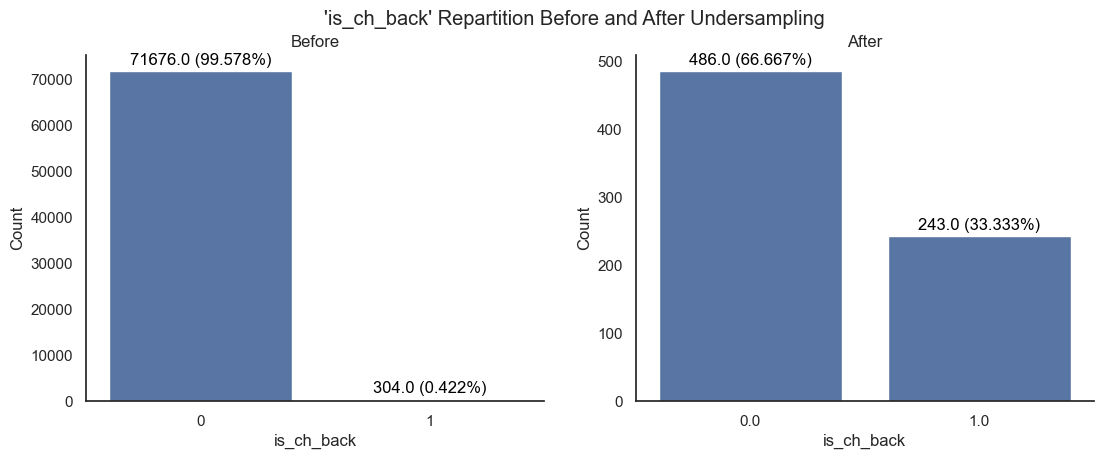

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style to white to remove background grids
sns.set(style="white")

# Assuming 'df' is your original DataFrame and 'y_train' is the Series after undersampling
fig, axs = plt.subplots(ncols=2, figsize=(13, 4.5))

# Plotting the distribution before undersampling
sns.countplot(x='is_ch_back', data=df, ax=axs[0])
axs[0].set_xlabel("is_ch_back")
axs[0].set_ylabel("Count")
sns.despine(ax=axs[0])

# Adding annotations on top of each bar
total_before = len(df)
for p in axs[0].patches:
    percentage = f'{100 * p.get_height() / total_before:.3f}%'
    axs[0].annotate(f'{p.get_height()} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Converting y_train to DataFrame with the correct column name
y_train_df = y_train.to_frame(name='is_ch_back')

# Plotting the distribution after undersampling
sns.countplot(x='is_ch_back', data=y_train_df, ax=axs[1])
axs[1].set_xlabel("is_ch_back")
axs[1].set_ylabel("Count")
sns.despine(ax=axs[1])

# Adding annotations on top of each bar
total_after = len(y_train_df)
for p in axs[1].patches:
    percentage = f'{100 * p.get_height() / total_after:.3f}%'
    axs[1].annotate(f'{p.get_height()} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

fig.suptitle("'is_ch_back' Repartition Before and After Undersampling")
a1 = fig.axes[0]
a1.set_title("Before")
a2 = fig.axes[1]
a2.set_title("After")

plt.show()


### פונקציות לאימון המודל  ביצוע ולדיציה מציאת היפר פרמטרים והצגת התוצאות

In [23]:
# פונקציה לציור גרף ROC בקיפול מוצלב
def draw_roc_curve_k_fold(tpr_list, fpr_list, auc, pred_threshold=0.5):
    """
    פונקציה לציור גרף ROC בקיפול מוצלב.
    
    פרמטרים:
    tpr_list: רשימת ערכי TPR מכל קיפול.
    fpr_list: רשימת ערכי FPR מכל קיפול.
    auc: ערך ה-AUC הממוצע.
    pred_threshold: סף חיזוי (ברירת מחדל: 0.5).
    """
    mean_tpr = pd.DataFrame(tpr_list).mean()  
    mean_fpr = pd.DataFrame(fpr_list).mean() 
    std_tpr = pd.DataFrame(tpr_list).std()   
    std_fpr = pd.DataFrame(fpr_list).std() 
    
    plt.figure(figsize=(8, 8))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='b', alpha=0.2, label='±1 std. dev.')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (10-Fold Cross-Validation)')
    plt.legend()
    plt.show()

# פונקציה לציור גרף חשיבות תכונות
def plot_feature_importance(mean_feature_importance, model_type, top_n=20, importance_type='Feature Importance'):
    """
    פונקציה לציור גרף חשיבות תכונות.
    
    פרמטרים:
    mean_feature_importance: סדרת ערכי חשיבות התכונות הממוצעים.
    model_type: סוג המודל.
    top_n: מספר התכונות המובילות להצגה (ברירת מחדל: 20).
    importance_type: סוג החשיבות (ברירת מחדל: 'Feature Importance').
    """
    top_features = mean_feature_importance.head(top_n)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.xlabel('Mean Importance')
    plt.ylabel('Features')
    plt.title(f'Top {top_n} {importance_type} for {model_type}')
    plt.show()

# פונקציה להערכת ביצועי המודל
def evaluate_model(y_test, y_pred, y_probabilities, cm):
    """
    פונקציה להערכת ביצועי המודל.
    
    פרמטרים:
    y_test: ערכי היעד האמיתיים.
    y_pred: ערכי היעד החזויים.
    y_probabilities: הסתברויות החיזוי של המודל.
    cm: מטריצת בלבול.
    
    מחזירה:
    precision, recall, specificity, f1, accuracy, auc, fpr, tpr
    """
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probabilities)
    fpr, tpr, _ = roc_curve(y_test, y_probabilities)
    return precision, recall, specificity, f1, accuracy, auc, fpr, tpr

# פונקציה ליצירת מודל רשת נוירונים
def create_nn_model(optimizer='adam', dropout_rate=0.2):
    """
    פונקציה ליצירת מודל רשת נוירונים.
    
    פרמטרים:
    optimizer: סוג האופטימיזטור (ברירת מחדל: 'adam').
    dropout_rate: שיעור ה-Dropout (ברירת מחדל: 0.2).
    
    מחזירה:
    אובייקט של מודל רשת נוירונים מאומן.
    """
    model = Sequential()
    model.add(Dense(32, input_shape=(X_processed_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# פונקציה ליצירת מודל קלאסי
def create_model(model_type, class_weights, best_params=None):
    """
    פונקציה ליצירת מודל קלאסי.
    
    פרמטרים:
    model_type: סוג המודל.
    class_weights: משקלים למחלקות.
    best_params: פרמטרים אופטימליים למודל (ברירת מחדל: None).
    
    מחזירה:
    אובייקט של המודל הנבחר מאומן.
    """
    classifiers = {
        "AdaBoost": AdaBoostClassifier(random_state=120, algorithm='SAMME'),
        "RandomForest": RandomForestClassifier(random_state=42, class_weight=class_weights),
        "GradientBoost": GradientBoostingClassifier(random_state=120),
        "DecisionTree": DecisionTreeClassifier(random_state=120, class_weight=class_weights),
        "LogisticRegression": LogisticRegression(random_state=120),
        "HistGradientBoost": HistGradientBoostingClassifier(random_state=120)
    }
    classifier = classifiers[model_type]
    if best_params:
        classifier.set_params(**best_params)
    return classifier
def search_hyperparameters(X, y, k, model_type, class_weights, pred_threshold, dropout_rate):
    """
    פונקציה לחיפוש היפר-פרמטרים אופטימליים עבור המודל הנתון.
    
    פרמטרים:
    X: תכונות הקלט.
    y: תוויות היעד.
    k: מספר הקיפולים בקיפול מוצלב.
    model_type: סוג המודל.
    class_weights: משקלים למחלקות.
    pred_threshold: סף חיזוי.
    dropout_rate: שיעור ה-Dropout עבור רשתות נוירונים.
    
    מחזירה:
    היפר-פרמטרים אופטימליים ורשימות של תוצאות מדדים שונים לכל קיפול.
    """
    param_grids = {
        "RandomForest": {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        "AdaBoost": {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 1]
        },
        "GradientBoost": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [3, 5, 10]
        },
        "DecisionTree": {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        },
        "LogisticRegression": {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2']
        },
        "HistGradientBoost": {
            'learning_rate': [0.01, 0.1, 1],
            'max_iter': [100, 200],
            'max_depth': [None, 10, 20]
        },
        "NeuralNetwork": {
            'batch_size': [5, 15, 25],
            'epochs': [5, 10, 16],
            'optimizer': ['adam', 'rmsprop']
        }
    }

    recall_scorer = make_scorer(recall_score)

    if model_type == "NeuralNetwork":
        best_score = 0
        best_params = {}
        TP, TN, FP, FN = [], [], [], []
        precision, recall, specificity, f1, accuracy, AUC = [], [], [], [], [], []
        tpr_list, fpr_list = [], []

        # קיפול מוצלב עבור רשתות נוירונים
        for batch_size in param_grids['NeuralNetwork']['batch_size']:
            for epochs in param_grids['NeuralNetwork']['epochs']:
                for optimizer in param_grids['NeuralNetwork']['optimizer']:
                    rskf = RepeatedStratifiedKFold(n_splits=k, n_repeats=1, random_state=78)
                    for train_index, test_index in rskf.split(X, y):
                        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                        # יצירת מודל רשת נוירונים
                        model = create_nn_model(optimizer=optimizer, dropout_rate=dropout_rate)
                        model.fit(X_train.values, y_train.values, batch_size=batch_size, epochs=epochs, verbose=0)
                        y_probabilities = model.predict(X_test.values)
                        y_pred = (y_probabilities >= pred_threshold).astype(int)

                        cm = confusion_matrix(y_test, y_pred)
                        TP.append(cm[1][1])
                        TN.append(cm[0][0])
                        FN.append(cm[0][1])
                        FP.append(cm[1][0])

                        # הערכת המודל והוספת תוצאות לרשימות
                        prec, rec, spec, f1_score, acc, auc, fpr, tpr = evaluate_model(y_test, y_pred, y_probabilities, cm)
                        precision.append(prec)
                        recall.append(rec)
                        specificity.append(spec)
                        f1.append(f1_score)
                        accuracy.append(acc)
                        AUC.append(auc)
                        tpr_list.append(tpr)
                        fpr_list.append(fpr)

                        # עדכון הפרמטרים הטובים ביותר
                        recall_current = recall_score(y_test, y_pred)
                        if recall_current > best_score:
                            best_score = recall_current
                            best_params = {'batch_size': batch_size, 'epochs': epochs, 'optimizer': optimizer}

        return best_params, TP, TN, FP, FN, precision, recall, specificity, f1, accuracy, AUC, tpr_list, fpr_list, None
    else:
        TP, TN, FP, FN = [], [], [], []
        precision, recall, specificity, f1, accuracy, AUC = [], [], [], [], [], []
        tpr_list, fpr_list = [], []
        best_params_list = []
        feature_importance_dict = {'features': list(X.columns)}

        rskf = RepeatedStratifiedKFold(n_splits=k, n_repeats=1, random_state=78)
        for train_index, test_index in rskf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # חיפוש היפר-פרמטרים באמצעות GridSearchCV
            grid_search = GridSearchCV(estimator=create_model(model_type, class_weights), param_grid=param_grids[model_type], cv=k, scoring=recall_scorer, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_classifier = grid_search.best_estimator_
            best_params_list.append(grid_search.best_params_)
            y_probabilities = best_classifier.predict_proba(X_test)[:, 1]
            y_pred = (y_probabilities >= pred_threshold).astype(int)

            cm = confusion_matrix(y_test, y_pred)
            TP.append(cm[1][1])
            TN.append(cm[0][0])
            FN.append(cm[0][1])
            FP.append(cm[1][0])

            # הערכת המודל והוספת תוצאות לרשימות
            prec, rec, spec, f1_score, acc, auc, fpr, tpr = evaluate_model(y_test, y_pred, y_probabilities, cm)
            precision.append(prec)
            recall.append(rec)
            specificity.append(spec)
            f1.append(f1_score)
            accuracy.append(acc)
            AUC.append(auc)
            tpr_list.append(tpr)
            fpr_list.append(fpr)

            # הוספת חשיבות התכונות במידת האפשר
            if model_type in ["RandomForest", "GradientBoost", "DecisionTree"]:
                feature_importances = best_classifier.feature_importances_
                feature_importance_dict[str(train_index)] = feature_importances
            else:
                result = permutation_importance(best_classifier, X_test, y_test, n_repeats=2, random_state=42)
                feature_importance_dict['permutation_importance'] = result.importances_mean

        # הצגת חשיבות התכונות
        if model_type not in ["LogisticRegression", "HistGradientBoost", "NeuralNetwork"]:
            feature_importance_df = pd.DataFrame(feature_importance_dict)
            mean_feature_importance = feature_importance_df.set_index(['features']).transpose().mean()
            mean_feature_importance = mean_feature_importance.sort_values(ascending=False)
            plot_feature_importance(mean_feature_importance, model_type, importance_type='Feature Importance')
        else:
            mean_feature_importance = pd.Series(feature_importance_dict['permutation_importance'], index=X.columns).sort_values(ascending=False)
            plot_feature_importance(mean_feature_importance, model_type, importance_type='Permutation Importance')

        return best_params_list[-1], TP, TN, FP, FN, precision, recall, specificity, f1, accuracy, AUC, tpr_list, fpr_list, mean_feature_importance


def k_cross_validation(X, y, model_type, k=10, class_weights={0: 1540, 1: 389}, pred_threshold=0.5, dropout_rate=0.2):
    """
    פונקציה לביצוע קיפול מוצלב עם חיפוש היפר-פרמטרים ואימון מחדש על כל סט האימון.
    
    פרמטרים:
    X: תכונות הקלט.
    y: תוויות היעד.
    model_type: סוג המודל.
    k: מספר הקיפולים בקיפול מוצלב (ברירת מחדל: 10).
    class_weights: משקלים למחלקות (ברירת מחדל: {0: 1540, 1: 389}).
    pred_threshold: סף חיזוי (ברירת מחדל: 0.5).
    dropout_rate: שיעור ה-Dropout עבור רשתות נוירונים (ברירת מחדל: 0.2).
    
    מחזירה:
    DataFrame עם תוצאות הקיפול המוצלב וחשיבות התכונות.
    """
    best_params, TP, TN, FP, FN, precision, recall, specificity, f1, accuracy, AUC, tpr_list, fpr_list, mean_feature_importance = search_hyperparameters(X, y, k, model_type, class_weights, pred_threshold, dropout_rate)

    results = pd.DataFrame({
        "TP": TP, "TN": TN, "FN": FN, "FP": FP, "Recall": recall,
        "Specificity": specificity, "Precision": precision, "F1-score": f1,
        "Accuracy": accuracy, "AUC": AUC
    })

    mean_recall_fold_results = results['Recall'].mean()
    std_recall_fold_results = results['Recall'].std()

    print(f"Mean Recall from fold results: {mean_recall_fold_results}")
    print(f"Standard Deviation Recall from fold results: {std_recall_fold_results}")

    df = pd.DataFrame({"mean": results.mean().round(decimals=4), "sd": results.std().round(decimals=3)})
    draw_roc_curve_k_fold(tpr_list, fpr_list, mean_recall_fold_results)

    # אימון המודל הטוב ביותר על כל סט האימון
    if model_type == "NeuralNetwork":
        model = create_nn_model(optimizer=best_params['optimizer'], dropout_rate=dropout_rate)
        model.fit(X.values, y.values, batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=0)
    else:
        model = create_model(model_type, class_weights, best_params)
        model.fit(X, y)

    # הערכת המודל על סט המבחן
    y_probabilities = model.predict_proba(X_processed_test)[:, 1] if model_type != "NeuralNetwork" else model.predict(X_processed_test.values)
    y_pred = (y_probabilities >= pred_threshold).astype(int)
    
    cm = confusion_matrix(y_test, y_pred)
    precision, recall, specificity, f1, accuracy, auc, fpr, tpr = evaluate_model(y_test, y_pred, y_probabilities, cm)
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Specificity: {specificity}")
    print(f"F1-score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")

    return df, mean_feature_importance ,best_params


### RECALL החזרת תוצאות אחרי אימון עם אופטימזיציה לפי שיטת 

### DecisionTreeCLassifier

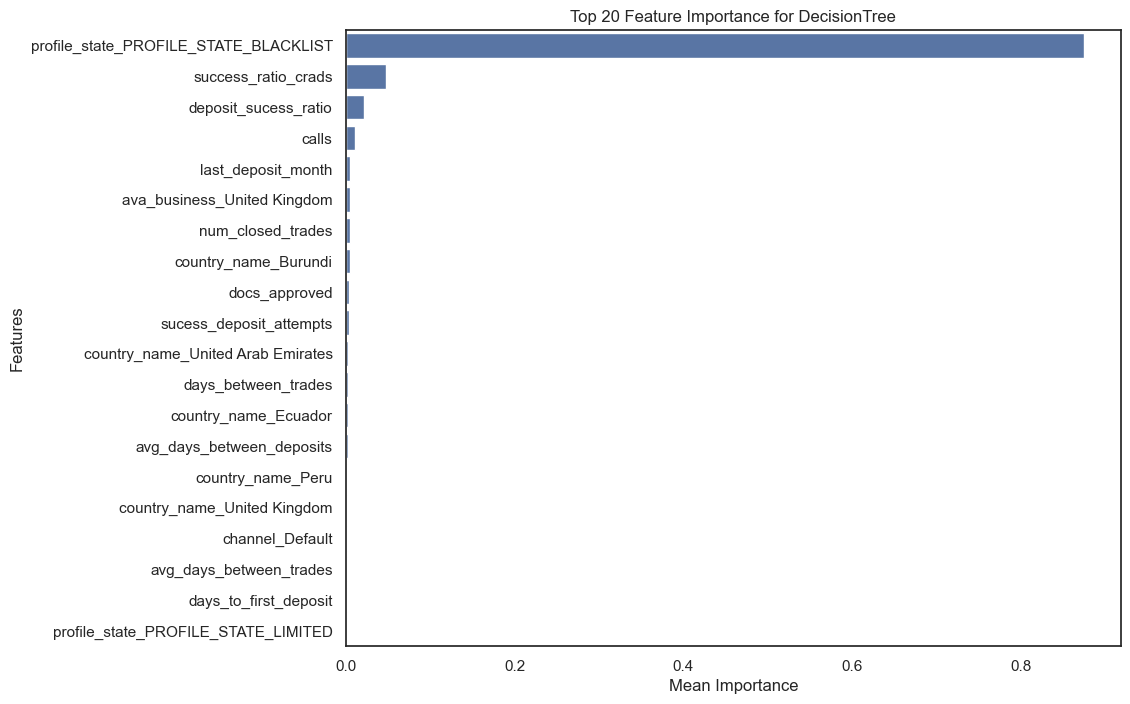

Mean Recall from fold results: 0.9670068027210885
Standard Deviation Recall from fold results: 0.011493755434764072


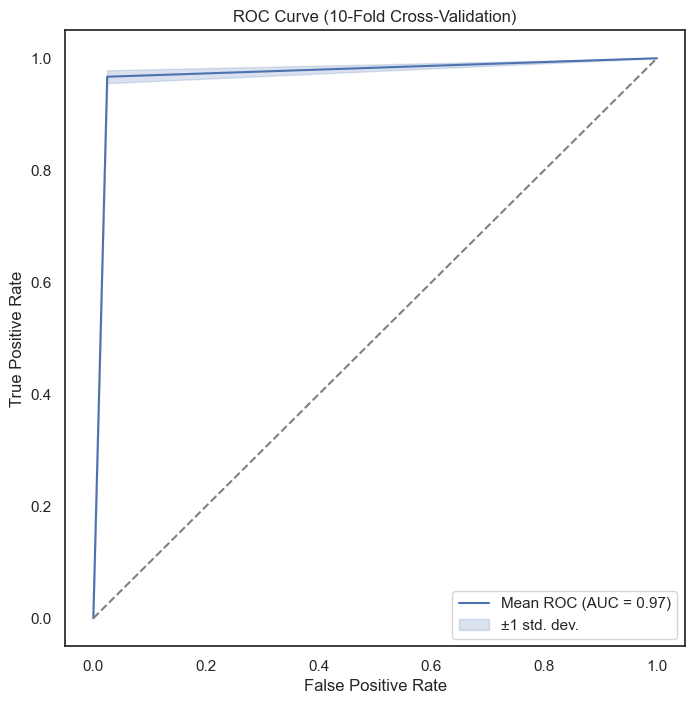

Confusion Matrix:
[[14157   178]
 [    2    59]]
Precision: 0.2489451476793249
Recall: 0.9672131147540983
Specificity: 0.9875828392047437
F1-score: 0.3959731543624161
Accuracy: 0.9874965268130036
AUC: 0.977397976979421


,mean,sd
TP,47.0000,1.000
TN,94.8000,1.095
FN,2.4000,1.342
FP,1.6000,0.548
Recall,0.9670,0.011
Specificity,0.9753,0.014
Precision,0.9517,0.027
F1-score,0.9592,0.016
Accuracy,0.9726,0.011
AUC,0.9712,0.010


In [24]:

dt_results_, dt_feature_importance , best_params_dt= k_cross_validation(X_processed_train,y_train, model_type="DecisionTree", k= 5 , class_weights=class_weights, pred_threshold=0.5)
dt_results_


### AdaBoostClassifier

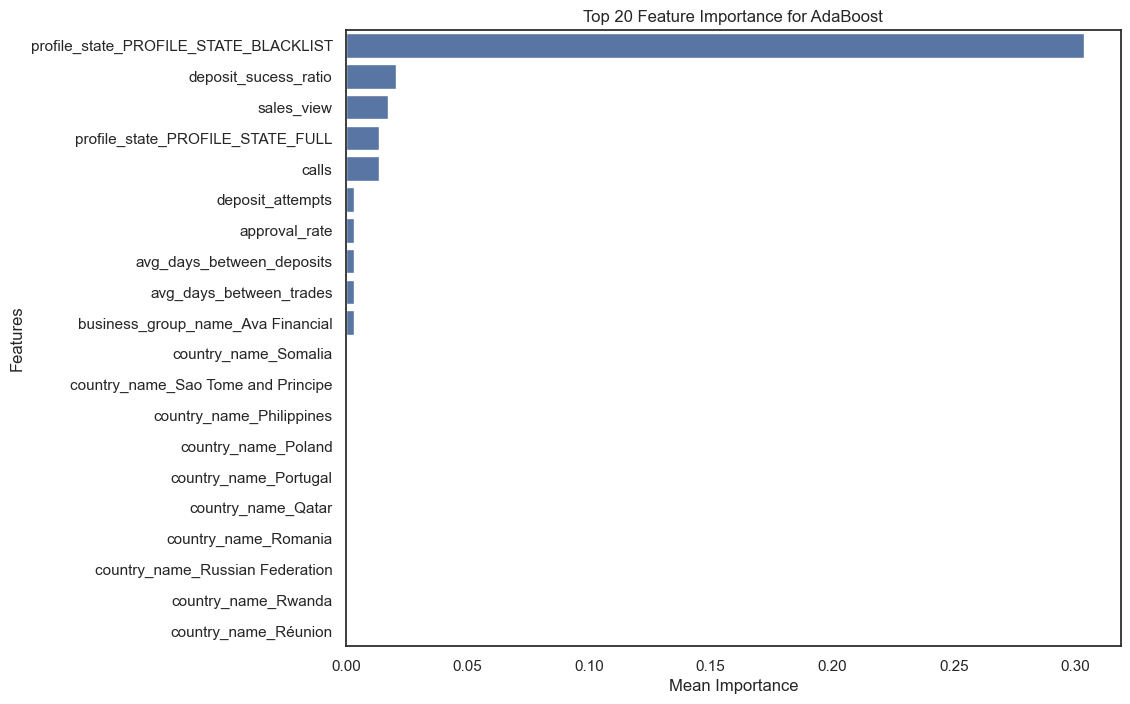

Mean Recall from fold results: 0.9712585034013606
Standard Deviation Recall from fold results: 0.023383580692231367


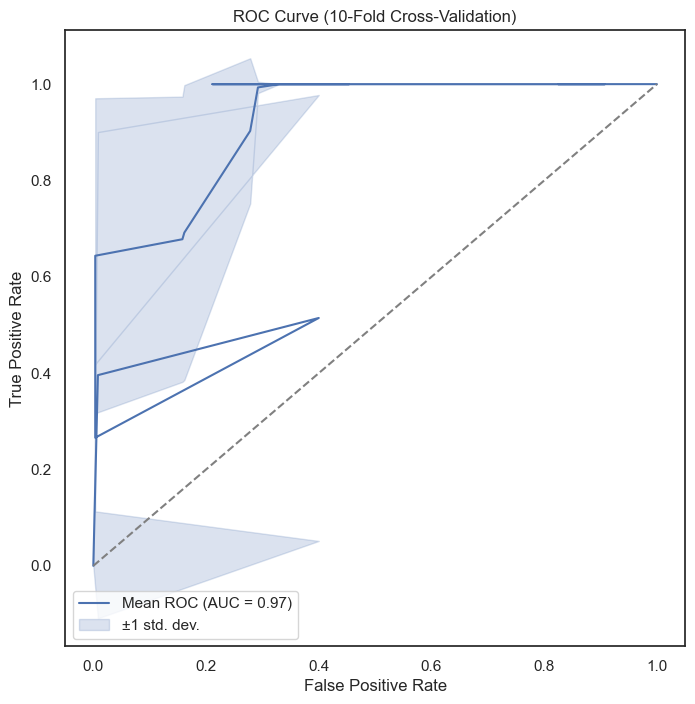

Confusion Matrix:
[[14197   138]
 [    2    59]]
Precision: 0.29949238578680204
Recall: 0.9672131147540983
Specificity: 0.9903732124171608
F1-score: 0.4573643410852713
Accuracy: 0.9902750764101139
AUC: 0.9930006232595905


,mean,sd
TP,47.2000,1.095
TN,96.0000,1.225
FN,1.2000,1.643
FP,1.4000,1.140
Recall,0.9713,0.023
Specificity,0.9877,0.017
Precision,0.9758,0.033
F1-score,0.9733,0.022
Accuracy,0.9822,0.015
AUC,0.9812,0.017


In [25]:

ab_results, ab_feature_importance , best_params_ab = k_cross_validation(X_processed_train,y_train, model_type="AdaBoost", k=5, class_weights=class_weights, pred_threshold=0.5)
ab_results


### RandomForestClassifier

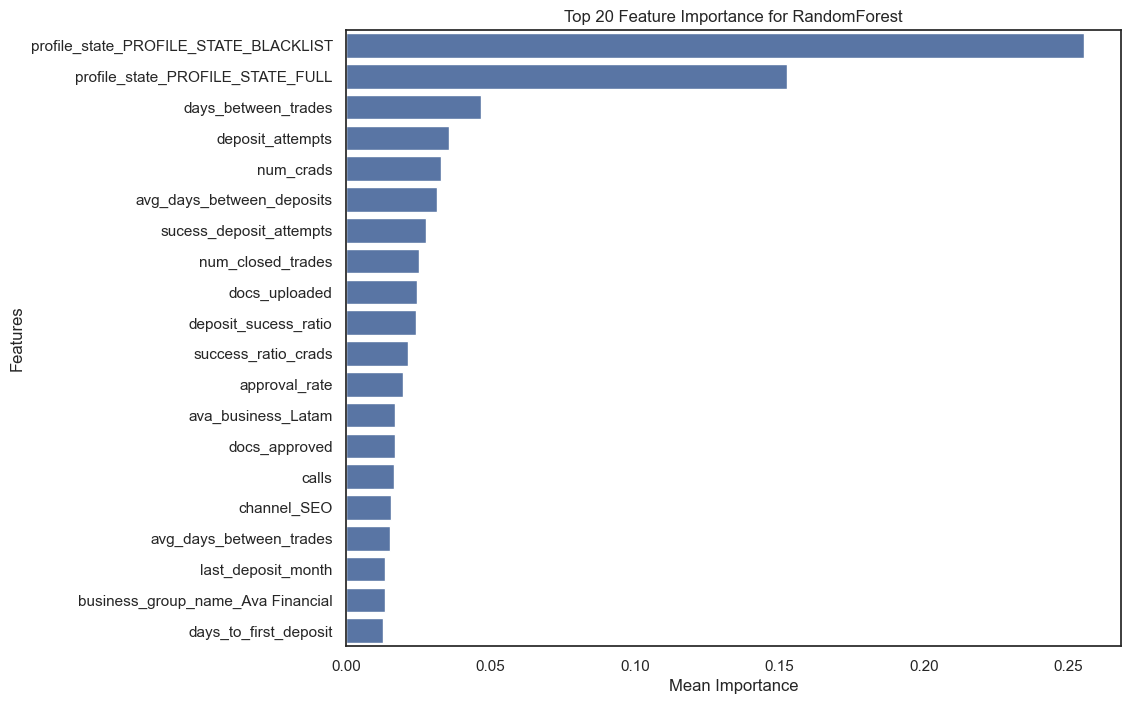

Mean Recall from fold results: 0.9794217687074831
Standard Deviation Recall from fold results: 0.02062315891653381


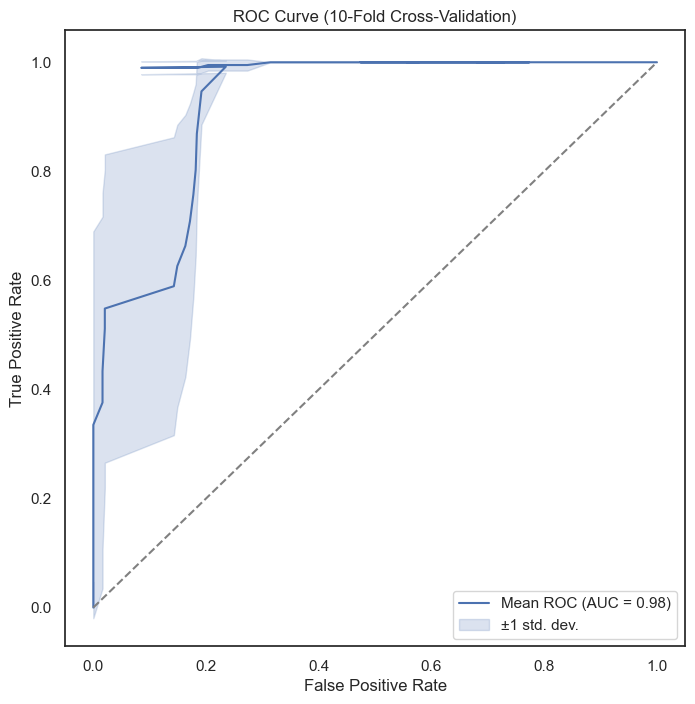

Confusion Matrix:
[[14168   167]
 [    1    60]]
Precision: 0.2643171806167401
Recall: 0.9836065573770492
Specificity: 0.9883501918381583
F1-score: 0.4166666666666667
Accuracy: 0.9883300916921367
AUC: 0.9963553608901747


,mean,sd
TP,47.6000,1.140
TN,96.2000,0.837
FN,1.0000,0.707
FP,1.0000,1.000
Recall,0.9794,0.021
Specificity,0.9897,0.007
Precision,0.9794,0.014
F1-score,0.9794,0.016
Accuracy,0.9863,0.011
AUC,0.9958,0.005


In [26]:
rf_results, rf_feature_importance , best_params_rf = k_cross_validation(X_processed_train,y_train, model_type="RandomForest", k=5, class_weights=class_weights, pred_threshold=0.5)
rf_results


### GradientBoostingClassifier

In [27]:
#gb_results, dt_feature_importance = k_cross_validation(X_processed_train,y_train, model_type="GradientBoost", k=5, class_weights=class_weights, pred_threshold=0.5)
#gb_results


### LogisticRegression

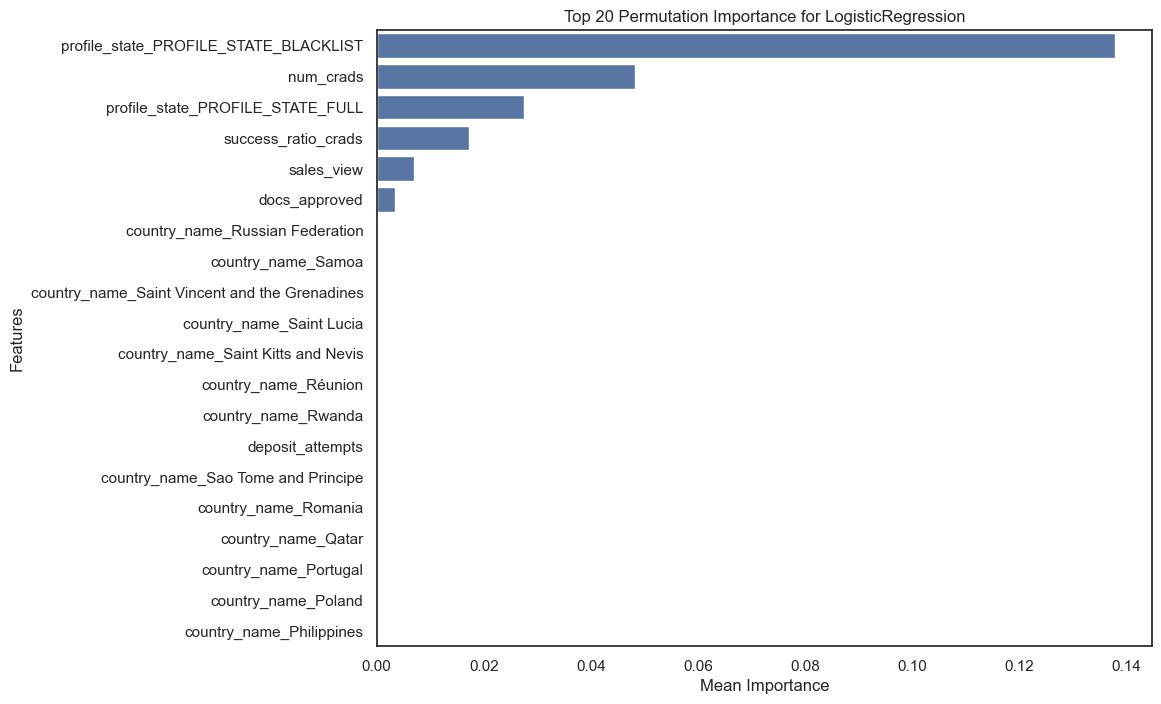

Mean Recall from fold results: 0.9752551020408164
Standard Deviation Recall from fold results: 0.009461347650136792


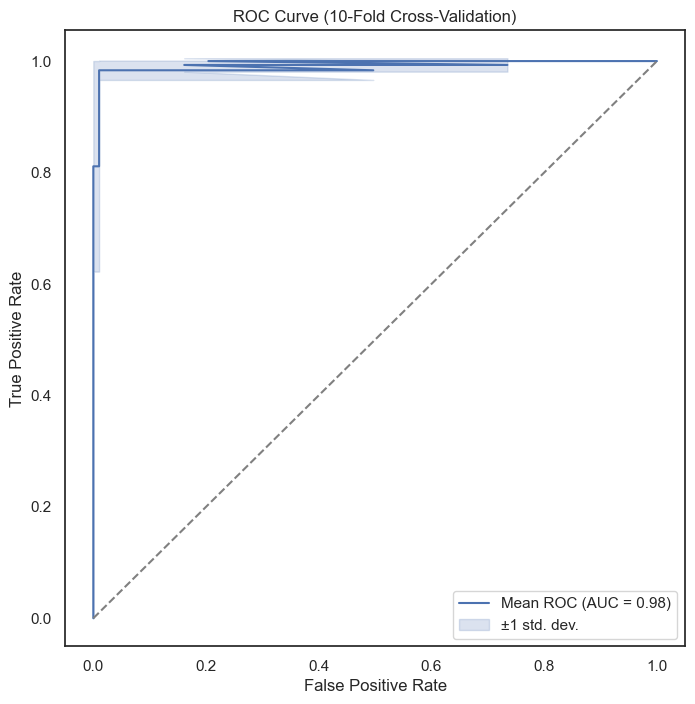

Confusion Matrix:
[[14174   161]
 [    1    60]]
Precision: 0.27149321266968324
Recall: 0.9836065573770492
Specificity: 0.9887687478200209
F1-score: 0.425531914893617
Accuracy: 0.9887468741317033
AUC: 0.9956314648887569


,mean,sd
TP,47.4000,0.894
TN,95.4000,1.342
FN,1.8000,1.789
FP,1.2000,0.447
Recall,0.9753,0.009
Specificity,0.9815,0.018
Precision,0.9640,0.035
F1-score,0.9694,0.022
Accuracy,0.9794,0.015
AUC,0.9954,0.004


In [28]:
lr_results, lr_feature_importance  , best_params_lr= k_cross_validation(X_processed_train,y_train, model_type="LogisticRegression", k=5, class_weights=class_weights, pred_threshold=0.5)
lr_results


### HistGradientBoostingClassifier

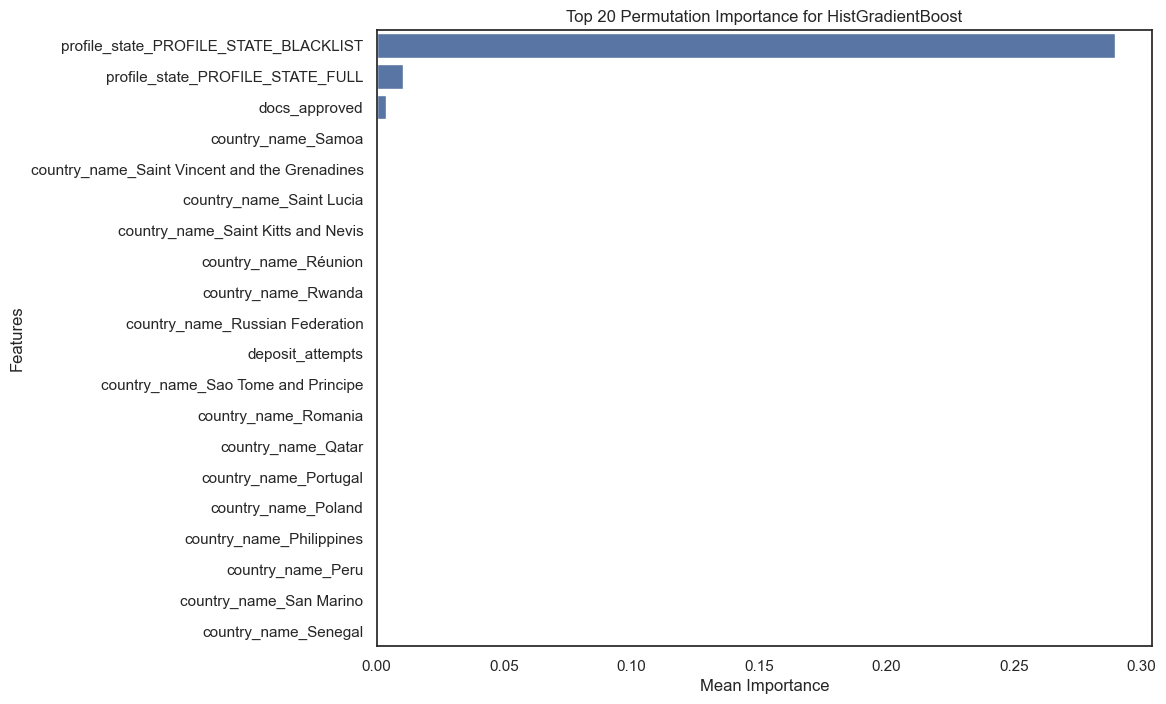

Mean Recall from fold results: 0.9712585034013606
Standard Deviation Recall from fold results: 0.023383580692231367


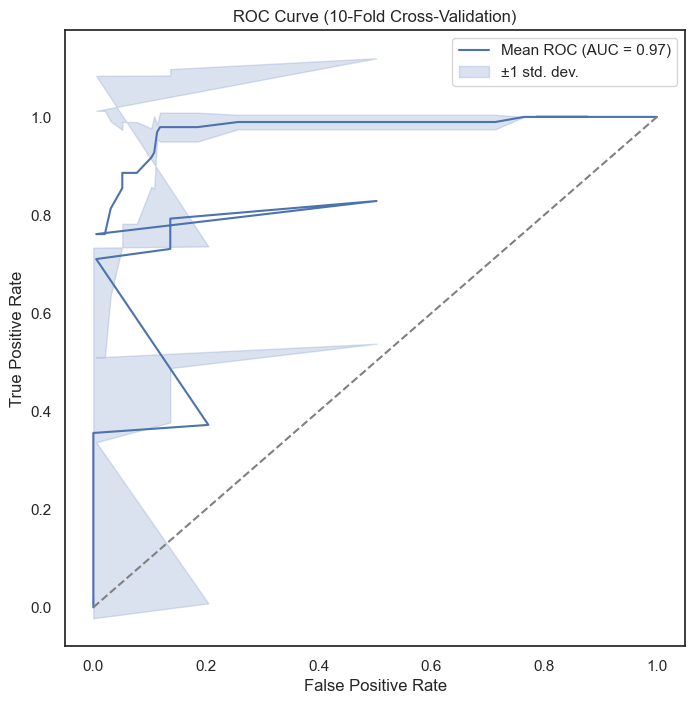

Confusion Matrix:
[[14213   122]
 [    2    59]]
Precision: 0.3259668508287293
Recall: 0.9672131147540983
Specificity: 0.9914893617021276
F1-score: 0.48760330578512395
Accuracy: 0.991386496248958
AUC: 0.9935947211628079


,mean,sd
TP,47.2000,1.095
TN,96.0000,1.225
FN,1.2000,1.643
FP,1.4000,1.140
Recall,0.9713,0.023
Specificity,0.9877,0.017
Precision,0.9758,0.033
F1-score,0.9733,0.022
Accuracy,0.9822,0.015
AUC,0.9870,0.011


In [29]:
hgb_results, hgb_feature_importance , best_params_hgb = k_cross_validation(X_processed_train,y_train, model_type="HistGradientBoost", k=5, class_weights=class_weights, pred_threshold=0.5)
hgb_results


### Sequential NN

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023B25453240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━

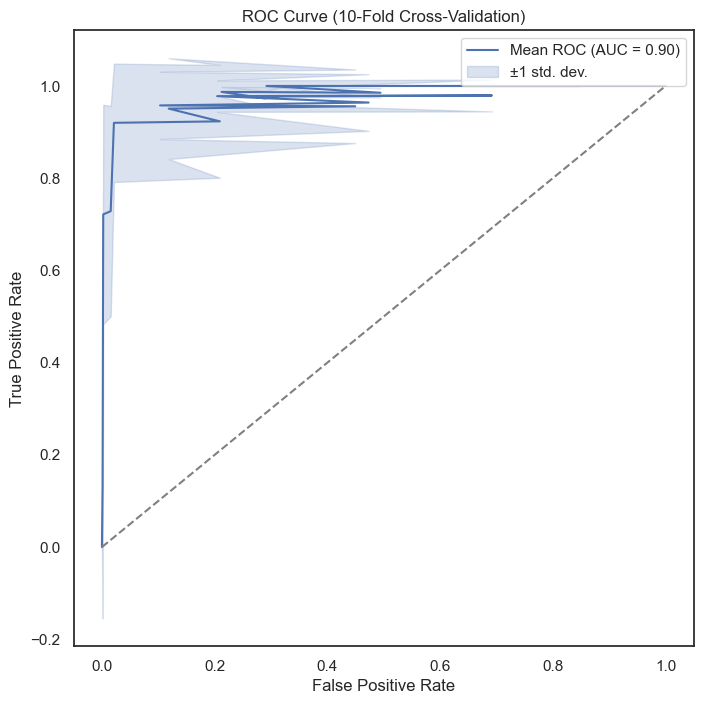

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion Matrix:
[[12668  1667]
 [    2    59]]
Precision: 0.034183082271147164
Recall: 0.9672131147540983
Specificity: 0.8837111963725148
F1-score: 0.06603245663122552
Accuracy: 0.8840650180605724
AUC: 0.978944118202039


,mean,sd
TP,43.8778,10.282
TN,95.2444,1.757
FN,1.9556,1.773
FP,4.7222,10.206
Recall,0.9025,0.211
Specificity,0.9799,0.018
Precision,0.9164,0.201
F1-score,0.9068,0.204
Accuracy,0.9542,0.067
AUC,0.9917,0.006


In [30]:
# קריאה לפונקציה עם כל הנתונים עבור רשתות נוירונים
nn_results, nn_feature_importance , best_params_nn= k_cross_validation(X_processed_train, y_train, model_type="NeuralNetwork", k=5, class_weights=class_weights, pred_threshold=0.5)
(nn_results)


## מודל היברידי משולב

In [49]:
def evaluate_voting_classifier_cv(X, y, k, class_weights, best_params_rf, best_params_hgb, best_params_lr):
    # הגדרת המודלים השונים
    clf1 = RandomForestClassifier(random_state=42, class_weight=class_weights, **best_params_rf)
    clf2 = HistGradientBoostingClassifier(random_state=42, **best_params_hgb)
    clf3 = LogisticRegression(random_state=42, **best_params_lr)

    # יצירת Voting Classifier
    voting_clf = VotingClassifier(estimators=[
        ('rf', clf1), 
        ('hgb', clf2), 
        ('lr', clf3)
    ], voting='soft')

    # Lists to hold the results
    TP, TN, FP, FN = [], [], [], []
    precision, recall, specificity, f1, accuracy, AUC = [], [], [], [], [], []
    tpr_list, fpr_list = [], []

    rskf = RepeatedStratifiedKFold(n_splits=k, n_repeats=1, random_state=78)
    for train_index, test_index in rskf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # אימון ה-Voting Classifier על כל סט האימון
        voting_clf.fit(X_train, y_train)

        # הערכת המודל על סט הבדיקה
        y_pred = voting_clf.predict(X_test)
        y_prob = voting_clf.predict_proba(X_test)[:, 1]

        # חישוב המדדים השונים
        precision_score, recall_score, specificity_score, f1_score, accuracy_score, auc, fpr, tpr = evaluate_model(y_test, y_pred, y_prob, confusion_matrix(y_test, y_pred))

        # Append the scores
        precision.append(precision_score)
        recall.append(recall_score)
        specificity.append(specificity_score)
        f1.append(f1_score)
        accuracy.append(accuracy_score)
        AUC.append(auc)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        cm = confusion_matrix(y_test, y_pred)
        TN.append(cm[0][0])
        FP.append(cm[0][1])
        FN.append(cm[1][0])
        TP.append(cm[1][1])

    results = pd.DataFrame({
        "TP": TP, "TN": TN, "FN": FN, "FP": FP, "Recall": recall,
        "Specificity": specificity, "Precision": precision, "F1-score": f1,
        "Accuracy": accuracy, "AUC": AUC
    })

    mean_recall_fold_results = results['Recall'].mean()
    std_recall_fold_results = results['Recall'].std()

    df = pd.DataFrame({"mean": results.mean().round(decimals=4), "sd": results.std().round(decimals=3)})

    return df

# דוגמה לשימוש בפונקציה
voting_results = evaluate_voting_classifier_cv(X_processed_train, y_train, k=5, class_weights=class_weights, best_params_rf=best_params_rf, best_params_hgb=best_params_hgb, best_params_lr=best_params_lr)
(voting_results)


,mean,sd
TP,47.2000,1.095
TN,95.4000,1.517
FN,1.4000,1.140
FP,1.8000,1.924
Recall,0.9713,0.023
Specificity,0.9815,0.020
Precision,0.9639,0.038
F1-score,0.9674,0.028
Accuracy,0.9781,0.019
AUC,0.9958,0.004


### איחוד התוצאות לטבלה מסכמת

In [50]:
# קיבוץ התוצאות לטבלה אחת
models = {
    'AdaBoost': ab_results,
    'RandomForest': rf_results,
    'DecisionTree': dt_results_,
    'LogisticRegression': lr_results,
    'HistGradientBoost': hgb_results,
    'Sequential_NN': nn_results,
    'Voting_CR': voting_results
}

combined_results = pd.DataFrame()

for model_name, results in models.items():
    # יצירת tuple של (mean, sd)
    results['Metric'] = results.index
    results['Model'] = model_name
    results['Mean_SD'] = list(zip(results['mean'], results['sd']))
    combined_results = pd.concat([combined_results, results[['Metric', 'Model', 'Mean_SD']]])

# יצירת טבלת pivot
combined_results_pivot = combined_results.pivot(index='Metric', columns='Model', values='Mean_SD')

# המרת הטבלה חזרה ל-DataFrame
final_df = pd.DataFrame(combined_results_pivot.to_records())

# הסרת האינדקסים והסדר הנכון של העמודות
final_df.columns = [col.replace("('", "").replace("', '')", "") for col in final_df.columns]

# הסרת האינדקסים המספריים
final_df = final_df.reset_index(drop=True)

# סידור העמודות לפי הסדר הרצוי
metrics_order = ["TN", "TP", "FN", "FP", "AUC", "Accuracy", "F1-score", "Precision", "Recall", "Specificity"]
final_df['Metric'] = pd.Categorical(final_df['Metric'], categories=metrics_order, ordered=True)
final_df = final_df.sort_values('Metric').reset_index(drop=True)

# הגדרת Metric כאינדקס
final_df.set_index('Metric', inplace=True)

# החזרת ה-DataFrame המסודר
#final_df



In [51]:
# פונקציה לחישוב ממוצע וסטיית תקן
def calculate_mean_sd(row):
    means = []
    sds = []
    for model in row.index:
        if model != 'Mean_SD_Summary':
            mean, sd = row[model]
            means.append(mean)
            sds.append(sd)
    mean_summary = round(pd.Series(means).mean(), 3)
    sd_summary = round(pd.Series(sds).std(), 3)
    return (mean_summary, sd_summary)


# הוספת העמודה המסכמת
final_df['Mean_SD_Summary'] = final_df.apply(calculate_mean_sd, axis=1)
final_df

,AdaBoost,DecisionTree,HistGradientBoost,LogisticRegression,RandomForest,Sequential_NN,Voting_CR,Mean_SD_Summary
Metric,,,,,,,,
TN,"(96.0, 1.225)","(94.8, 1.095)","(96.0, 1.225)","(95.4, 1.342)","(96.2, 0.837)","(95.2444, 1.757)","(95.4, 1.517)","(95.578, 0.295)"
TP,"(47.2, 1.095)","(47.0, 1.0)","(47.2, 1.095)","(47.4, 0.894)","(47.6, 1.14)","(43.8778, 10.282)","(47.2, 1.095)","(46.783, 3.489)"
FN,"(1.2, 1.643)","(2.4, 1.342)","(1.2, 1.643)","(1.8, 1.789)","(1.0, 0.707)","(1.9556, 1.773)","(1.4, 1.14)","(1.565, 0.398)"
FP,"(1.4, 1.14)","(1.6, 0.548)","(1.4, 1.14)","(1.2, 0.447)","(1.0, 1.0)","(4.7222, 10.206)","(1.8, 1.924)","(1.875, 3.5)"
AUC,"(0.9812, 0.017)","(0.9712, 0.01)","(0.987, 0.011)","(0.9954, 0.004)","(0.9958, 0.005)","(0.9917, 0.006)","(0.9958, 0.004)","(0.988, 0.005)"
Accuracy,"(0.9822, 0.015)","(0.9726, 0.011)","(0.9822, 0.015)","(0.9794, 0.015)","(0.9863, 0.011)","(0.9542, 0.067)","(0.9781, 0.019)","(0.976, 0.02)"
F1-score,"(0.9733, 0.022)","(0.9592, 0.016)","(0.9733, 0.022)","(0.9694, 0.022)","(0.9794, 0.016)","(0.9068, 0.204)","(0.9674, 0.028)","(0.961, 0.069)"
Precision,"(0.9758, 0.033)","(0.9517, 0.027)","(0.9758, 0.033)","(0.964, 0.035)","(0.9794, 0.014)","(0.9164, 0.201)","(0.9639, 0.038)","(0.961, 0.065)"
Recall,"(0.9713, 0.023)","(0.967, 0.011)","(0.9713, 0.023)","(0.9753, 0.009)","(0.9794, 0.021)","(0.9025, 0.211)","(0.9713, 0.023)","(0.963, 0.073)"


### אימון המודל שנבחר והצגת תוצאות

In [52]:
# הגדרת הפרמטרים הטובים ביותר עבור המודל
best_params = best_params_hgb

# אימון המודל הסופי עם הפרמטרים הטובים ביותר על כל סט האימון
final_model = HistGradientBoostingClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    max_iter=best_params['max_iter'],
    random_state=120
)
final_model.fit(X_processed_train, y_train)

# ביצוע ניבוי על סט הבדיקה
y_probabilities = final_model.predict_proba(X_processed_test)[:, 1]
y_pred = (y_probabilities >= 0.5).astype(int)

# חישוב המדדים השונים
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probabilities)
fpr, tpr, _ = roc_curve(y_test, y_probabilities)


# הצגת התוצאות בטבלה מסודרת לרוחב
tn, fp, fn, tp = cm.ravel()

results_df = pd.DataFrame({
    'Metric': ['TN', 'TP', 'FN', 'FP', 'Precision', 'Recall', 'Specificity', 'F1-score', 'Accuracy', 'AUC'],
    'Score': [tn, tp, fn, fp, precision, recall, specificity, f1, accuracy, auc]
}).set_index('Metric').T
(results_df)


Metric,TN,TP,FN,FP,Precision,Recall,Specificity,F1-score,Accuracy,AUC
Score,14213.0,59.0,2.0,122.0,0.325967,0.967213,0.991489,0.487603,0.991386,0.993595


### Confusion Matrix Heatmap

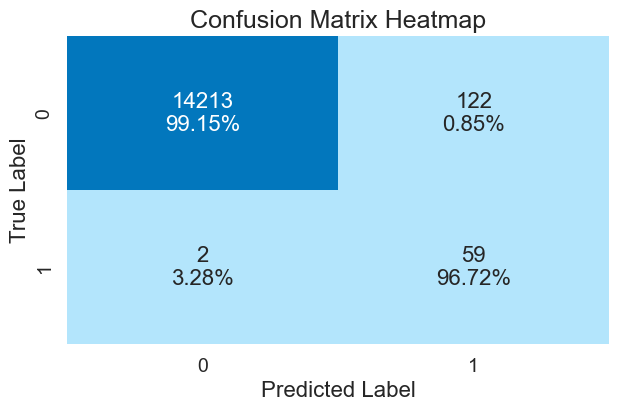

In [35]:
# יצירת פלטת צבעים מותאמת אישית
colors = ['#B3E5FC', '#0277BD']  # תכלת כהה יותר וכחול
cmap = sns.color_palette(colors, as_cmap=True)

# חישוב אחוזי הדיוק לכל תא במטריצת הבלבול
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100

# יצירת תוויות המשלבות את המספרים המוחלטים ואת האחוזים
annot = np.array([f'{v1}\n{v2:.2f}%' for v1, v2 in zip(cm.flatten(), cm_perc.flatten())])
annot = annot.reshape(cm.shape)

# יצירת המפה החום עם אחוזים
plt.figure(figsize=(7, 4))
sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, cbar=False, annot_kws={"size": 16})  # הגדלת הכתב בפנים
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('Confusion Matrix Heatmap', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


### ROC הצגת גרף 

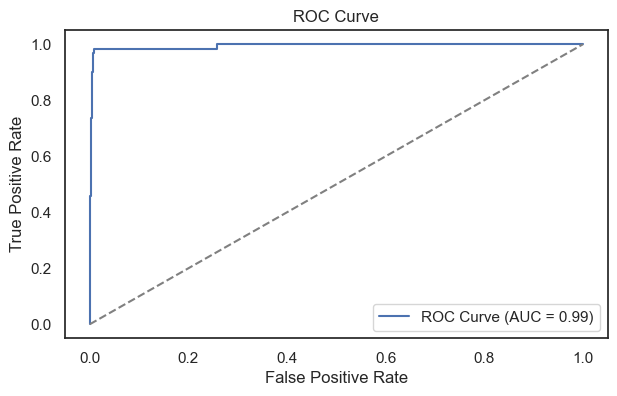

In [36]:
# Plot ROC curve
plt.figure(figsize=(7, 4))
plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### הצגת גרף בוקספלוט משולב כם סקאטרפלוט של הסתברות להכחשת עסקה מול הכשה בפועל

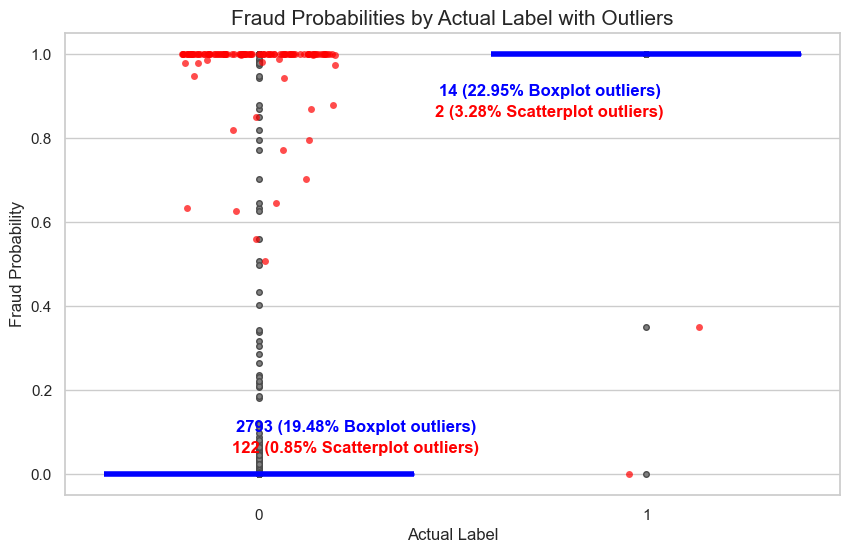

In [55]:
# הצגת ההסתברויות להונאה עבור כל לקוח בסט הבדיקה
fraud_probabilities = y_probabilities

# הוספת ההסתברויות ל-DataFrame של הלקוחות
customers_with_probabilities = pd.DataFrame(X_processed_test.copy())
customers_with_probabilities['Fraud_Probability'] = fraud_probabilities
customers_with_probabilities['Actual_Label'] = y_test.values

# הגדרת חריגים לפי הגדרות שלך עבור הסקאטרפלוט
scatter_outliers = customers_with_probabilities[
    ((customers_with_probabilities['Actual_Label'] == 0) & (customers_with_probabilities['Fraud_Probability'] > 0.5)) |
    ((customers_with_probabilities['Actual_Label'] == 1) & (customers_with_probabilities['Fraud_Probability'] < 0.5))
]

# יצירת הגרף הכולל גם Boxplot וגם Scatterplot של חריגים
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# גרף התיבות (Boxplot) המציג את כל הנתונים
boxprops = dict(color='blue', linewidth=2)
medianprops = dict(color='blue', linewidth=4)  # הדגשת החציון עם קו עבה יותר
whiskerprops = dict(color='blue', linewidth=2)
capprops = dict(color='blue', linewidth=2)

boxplot = sns.boxplot(
    x='Actual_Label', y='Fraud_Probability', data=customers_with_probabilities, 
    boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops,
    showcaps=False, flierprops={"marker": "o", "markersize": 4, "markerfacecolor": "gray"}
)

# גרף פיזור המציג רק את החריגים לפי ההגדרות שלך
sns.stripplot(x='Actual_Label', y='Fraud_Probability', data=scatter_outliers, color='red', alpha=0.7, jitter=0.2)

# הוספת תוויות ציר
plt.xlabel('Actual Label', fontsize=12)
plt.ylabel('Fraud Probability', fontsize=12)
plt.title('Fraud Probabilities by Actual Label with Outliers', fontsize=15)

# חישוב והוספת אחוזים וכמות חריגים על גבי הגרף
for label in [0, 1]:
    subset = customers_with_probabilities[customers_with_probabilities['Actual_Label'] == label]['Fraud_Probability']
    q1 = subset.quantile(0.25)
    q3 = subset.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    boxplot_outliers = subset[(subset < lower_bound) | (subset > upper_bound)]

    # חישוב אחוזים וכמות חריגים
    boxplot_outlier_count = len(boxplot_outliers)
    scatter_outlier_count = len(scatter_outliers[scatter_outliers['Actual_Label'] == label])
    total_count = len(customers_with_probabilities[customers_with_probabilities['Actual_Label'] == label])
    
    boxplot_outlier_percent = (boxplot_outlier_count / total_count) * 100
    scatter_outlier_percent = (scatter_outlier_count / total_count) * 100
    
    boxplot_text = f'{boxplot_outlier_count} ({boxplot_outlier_percent:.2f}% Boxplot outliers)'
    scatter_text = f'{scatter_outlier_count} ({scatter_outlier_percent:.2f}% Scatterplot outliers)'
    
    # מיקום הטקסט בצורה יותר לכיוון המרכז
    x_pos = label + 0.25 if label == 0 else label - 0.25
    y_pos = 0.9 if label == 1 else 0.1
    
    plt.text(x_pos, y_pos, boxplot_text, 
             horizontalalignment='center', size='medium', color='blue', weight='semibold')
    
    plt.text(x_pos, y_pos - 0.05, scatter_text, 
             horizontalalignment='center', size='medium', color='red', weight='semibold')

plt.show()



### הצגת גרף חשיבות עמודות

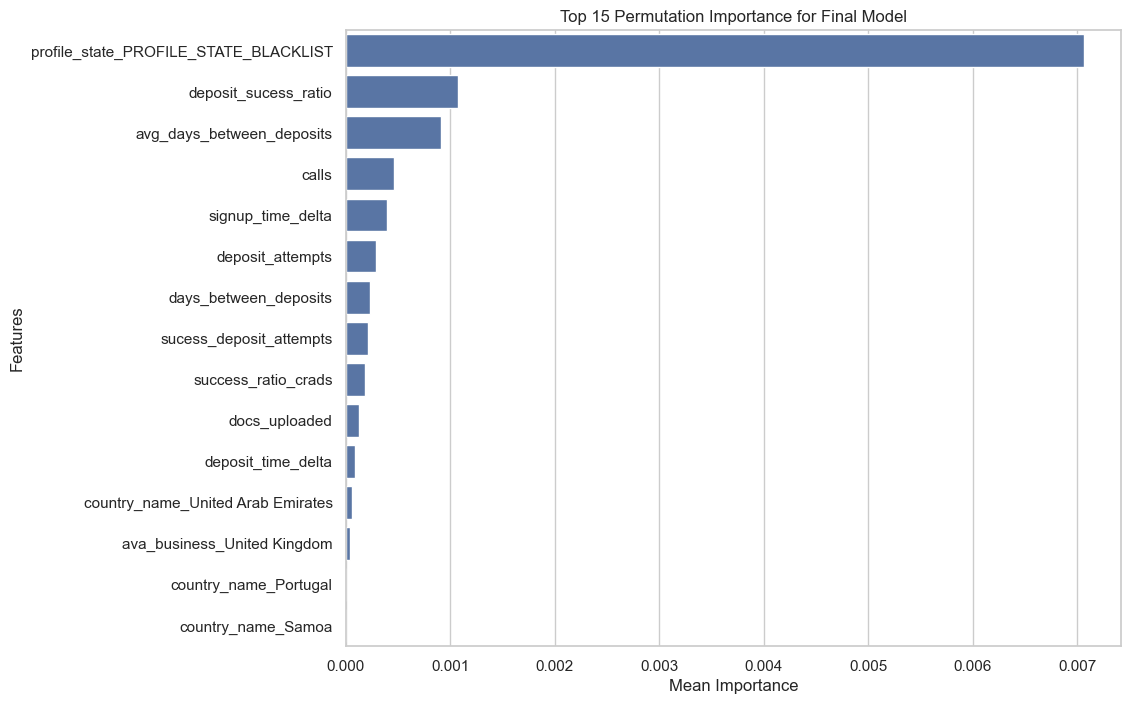

In [58]:
# חישוב חשיבות העמודות עבור המודל הסופי
result = permutation_importance(final_model, X_processed_test, y_test, n_repeats=10, random_state=42)

# המרת התוצאות לסדרת פנדס ומיון לפי חשיבות
importance_df = pd.Series(result.importances_mean, index=X_processed_test.columns).sort_values(ascending=False)

# הצגת הגרף עבור 15 העמודות החשובות ביותר
plot_feature_importance(importance_df.head(15), 'Final Model', importance_type='Permutation Importance',top_n= 15)


### הצגת גרף תדירות הסתברויות להכחשת עסקה

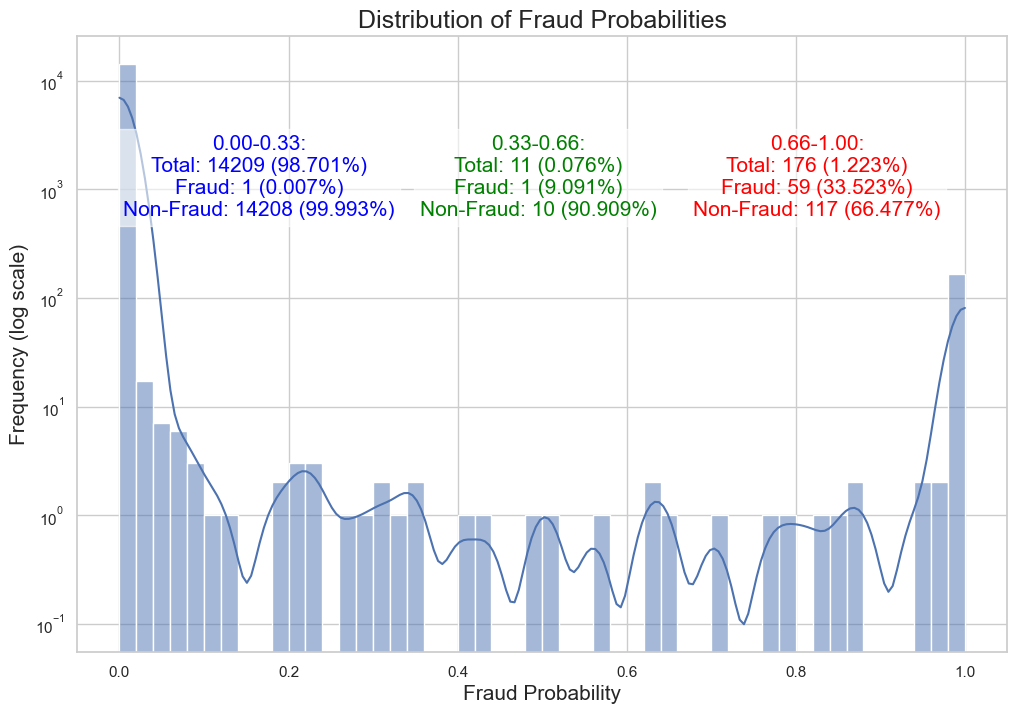

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'customers_with_probabilities' DataFrame is available
plt.figure(figsize=(12, 8))
sns.histplot(customers_with_probabilities['Fraud_Probability'], bins=50, kde=True)
plt.yscale('log')
plt.xlabel('Fraud Probability', fontsize=15)
plt.ylabel('Frequency (log scale)', fontsize=15)
plt.title('Distribution of Fraud Probabilities', fontsize=18)

# Calculating the counts and percentages for different probability ranges
ranges = [(0.0, 0.33), (0.33, 0.66), (0.66, 1.0)]
colors = ['blue', 'green', 'red']
labels = []
for i, (start, end) in enumerate(ranges):
    range_cases = customers_with_probabilities[(customers_with_probabilities['Fraud_Probability'] >= start) & 
                                               (customers_with_probabilities['Fraud_Probability'] < end)]
    total_count = len(range_cases)
    total_percentage = (total_count / len(customers_with_probabilities)) * 100

    fraud_cases = range_cases[range_cases['Actual_Label'] == 1]
    fraud_count = len(fraud_cases)
    fraud_percentage = (fraud_count / total_count) * 100 if total_count > 0 else 0

    non_fraud_cases = range_cases[range_cases['Actual_Label'] == 0]
    non_fraud_count = len(non_fraud_cases)
    non_fraud_percentage = (non_fraud_count / total_count) * 100 if total_count > 0 else 0

    labels.append(f'{start:.2f}-{end:.2f}:\nTotal: {total_count} ({total_percentage:.3f}%)\n'
                  f'Fraud: {fraud_count} ({fraud_percentage:.3f}%)\n'
                  f'Non-Fraud: {non_fraud_count} ({non_fraud_percentage:.3f}%)')

# Displaying the counts and percentages on the plot
for i, label in enumerate(labels):
    plt.text(0.165 + i * 0.33, 10**3.5, label,
             fontsize=15, color=colors[i], ha='center', va='top', bbox=dict(facecolor='white', alpha=0.6))

plt.show()



### החזרת טבלה עם פרטים חשובים של לקוחות בעלי סיכוי גבוה להכחשת עסקה

In [43]:
# Reverse the numerical transformations (StandardScaler)
X_numeric_restored_test = scaler.inverse_transform(X_numeric_scaled_test)
X_numeric_restored_test = pd.DataFrame(X_numeric_restored_test, columns=X_numeric_test.columns).reset_index(drop=True)

# Reverse the categorical transformations (OneHotEncoder)
X_categorical_restored_test = one_hot_encoder.inverse_transform(X_categorical_encoded_test)
X_categorical_restored_test = pd.DataFrame(X_categorical_restored_test, columns=categorical_columns).reset_index(drop=True)

# Combine the reversed numerical and categorical data
X_restored_test = pd.concat([X_numeric_restored_test, X_categorical_restored_test], axis=1).reset_index(drop=True)

# Add the original date and additional columns back to the restored test set
final_restored_test = pd.concat([X_test_additional,X_restored_test, X_test_dates], axis=1).reset_index(drop=True)

# Add predictions to the restored test set
final_restored_test['Fraud_Probability'] = y_probabilities*100
final_restored_test['Actual_Label'] = y_test.reset_index(drop=True).values

In [44]:
import pandas as pd

# עיגול הערכים בעמודת Fraud_Probability לשלוש ספרות אחרי הנקודה
final_restored_test['Fraud_Probability'] = final_restored_test['Fraud_Probability'].round(3)

# הוספת עמודת זיהוי הונאה
threshold = 0.5
final_restored_test['Fraud_Label'] = final_restored_test['Fraud_Probability'] > threshold

# מיון הנתונים לפי הסתברות להונאה בסדר יורד
#final_restored_test = final_restored_test.sort_values(by='Fraud_Probability', ascending=False)

# בחירת העמודות להצגה
selected_columns = ['user', 'conversion_owner', 'tag', 'country_name', 'business_group_name', 'account_create_on_date', 'Fraud_Probability', 'Fraud_Label']

# הצגת הטבלה לאחר השינויים
(final_restored_test[selected_columns])

# שמירת הטבלה כקובץ CSV
#final_restored_test[selected_columns].to_csv('fraud_predictions.csv', index=False)


,user,conversion_owner,tag,country_name,business_group_name,account_create_on_date,Fraud_Probability,Fraud_Label
0,14669433,AvaFX Customer Service,185134,Colombia,Ava Financial,2023-03-09,0.000,False
1,15071430,AD Unassigned,avafx,Brazil,Ava Financial,2023-06-26,99.984,True
2,15946975,Giuseppe Moscato,avafx,Italy,Ava Capital,2024-01-04,0.000,False
3,16530149,AvaFX Customer Service,fusionpartners_google_za_search_nonbrand,South Africa,Ava Financial,2024-07-23,0.000,False
4,14617898,AvaFX Customer Service,126295,Mexico,Ava Financial,2023-02-15,0.001,False
...,...,...,...,...,...,...,...,...
14391,14618811,Daniel Krastev,2195,South Africa,Ava Financial,2023-02-15,0.000,False
14392,16046291,S Adler,188233,Austria,Ava Capital,2024-02-04,0.000,False
14393,16338307,Tsvetan Metodiev Petrov,avafx,Bangladesh,Ava Financial,2024-05-14,0.000,False
14394,15786228,Teddy Orenstein,62206,Germany,Ava Capital,2023-11-13,0.322,False
